# Predict housing prices

## Background

The [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) dataset from Kaggle has sale prices of residential homes in Ames, Iowa from 2006 to 2010 and 79 explanatory variables that may have impact on housing prices. With proper feature engineering and regression techniques, we can reasonably predict the price of every home. Let's model away!

## Getting data
First, we need to query the data from the Thinkful PostgreSQL database. 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from scipy import stats
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

style.use("fivethirtyeight")
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import (
    RidgeCV,
    LassoCV,
    ElasticNetCV,
    Ridge,
    Lasso,
    ElasticNet,
    LinearRegression,
)
from sklearn.model_selection import cross_val_score


import warnings

warnings.filterwarnings("ignore")

%load_ext lab_black

In [2]:
# PostgreSQL credentials
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
raw = pd.read_sql_query("select * from houseprices", con=engine)

# Close connection after the query
engine.dispose()

## Data cleaning
No matter what methods we use, we need to clean the raw data before using it to build predictive models. Particularly, we want to check whether the **data type** of each variable matches its description and whether there are **missing values** or **outliers**. 

Should we clean data before or after train/test split? It depends on what kind of cleaning we're doing. For data types and missing values, I'd like to inspect the entire dataset. If some variables are represented in a wrong format or if missing values are not labeled correctly, the changes are going to apply to all data points uniformly. However, I think we should only inspect and potentially deal with outliers after the split since which values are considered outliers depend on other values. The philosophy behind this is that we should treat test data as future data that we don't yet posses; if a decision depends on the exact values of the data, we should only do it based on the training data while being agnostic to the test data.

### Clean entire dataset 

#### Data type
How many variables are categorical (discrete) and how many are numeric (continuous)?

In [3]:
print(
    "The housing price data has {} rows and {} columns.\n".format(
        raw.shape[0], raw.shape[1]
    )
)

discrete_cols = raw.select_dtypes(include=["object"])
continuous_cols = raw.select_dtypes(include=["number"])

print(
    "{} columns contain strings and {} contain numeric values.".format(
        discrete_cols.shape[1], continuous_cols.shape[1]
    )
)

The housing price data has 1460 rows and 81 columns.

43 columns contain strings and 38 contain numeric values.


However, not all numeric columns represent continuous variables. According to the [data description](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/EGpnHbJBO1XGF5B35WNU%2Fversions%2FHOSha0bPv4HEBGjo9O9x%2Ffiles%2Fdata_description.txt) on Kaggle, "mssubclass" indicates the type of dwelling involved in the sale; while each type is assigned a numeric value, the numbers don't convey continuous quantities but discrete types. By definition, "msssubclass" is a nominal categorical variable. The only other case like this is "id", where a numeric value indicates a unique home. So in reality, the housing price data has 44 discrete variables and 36 continuous variables. 

To ease future use, we can covert "mssubclass" to strings. To avoid modifying the raw data, we can create a new data frame to store cleaned data.

In [4]:
# Create a new data frame
df = raw.copy()

# Convert mssubclass to string
df["mssubclass"] = df["mssubclass"].astype(str)

#### Missing data
Let's find out which columns have missing values and the proportion of data missing in each column.

In [5]:
# Find columns with missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=["total", "percent"])
missing = missing.loc[missing["total"] > 0, :]

missing

,total,percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


Among the 19 columns with missing values, six have over 15% data missing. Initially, I wanted to drop these columns altogether. However, after reading the data description again, I realized that some columns use missing values to indicate "none" rather than "unknown", which is quite misleading! For instance, a missing value in "poolqc" means that a house has no pool rather than there's no data on whether it has pools. 

Let's replace missing values with a new category called "None" in these columns.

In [6]:
cols_fillna = [
    "poolqc",
    "miscfeature",
    "alley",
    "fence",
    "masvnrtype",
    "fireplacequ",
    "garagequal",
    "garagecond",
    "garagefinish",
    "garagetype",
    "electrical",
    "kitchenqual",
    "saletype",
    "functional",
    "exterior2nd",
    "exterior1st",
    "bsmtexposure",
    "bsmtcond",
    "bsmtqual",
    "bsmtfintype1",
    "bsmtfintype2",
    "mszoning",
    "utilities",
]

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df[col].fillna("None", inplace=True)

Let's check for missing values again.

In [7]:
# Find columns with missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=["total", "percent"])
missing = missing.loc[missing["total"] > 0, :]

missing

,total,percent
lotfrontage,259,0.177397
garageyrblt,81,0.055479
masvnrarea,8,0.005479


Only 3 columns still have missing values. Since "lotfrontage" has over 17% of the data missing, we can drop this column. For the other two columns, we can wait until feature engineering to decide; whether we want to keep them depends on whether they are informative or not. For a predictive modeling project like this, we need to be cautious about imputing or interpolating missing values as it may change our predictions. 

In [8]:
# Drop lotfronatge from the data
df = df.drop("lotfrontage", axis=1)

### Clean test data
As discussed, if data cleaning depends on the exact values of the data, we should do it separately for the training data and the test data. The same consideration applies to both outlier detection and subsequent data exploration and feature engineering.

#### Train/test split
We can use 80% of the housing price data to train our models and save up 20% to examine model performance.

In [9]:
# Y is the target variable that we're are trying to predict
Y = df[df.columns[-1]]

# X is the feature set used to predict house prices
X = df[df.columns[:-1]]

# Create training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=465
)

df_train = pd.concat([X_train, y_train.reindex(X_train.index)], axis=1)

df_test = pd.concat([X_test, y_test.reindex(X_test.index)], axis=1)

#### Outliers
For continuous variables ("id" not included), we can first use box plots to visually detect outliers.

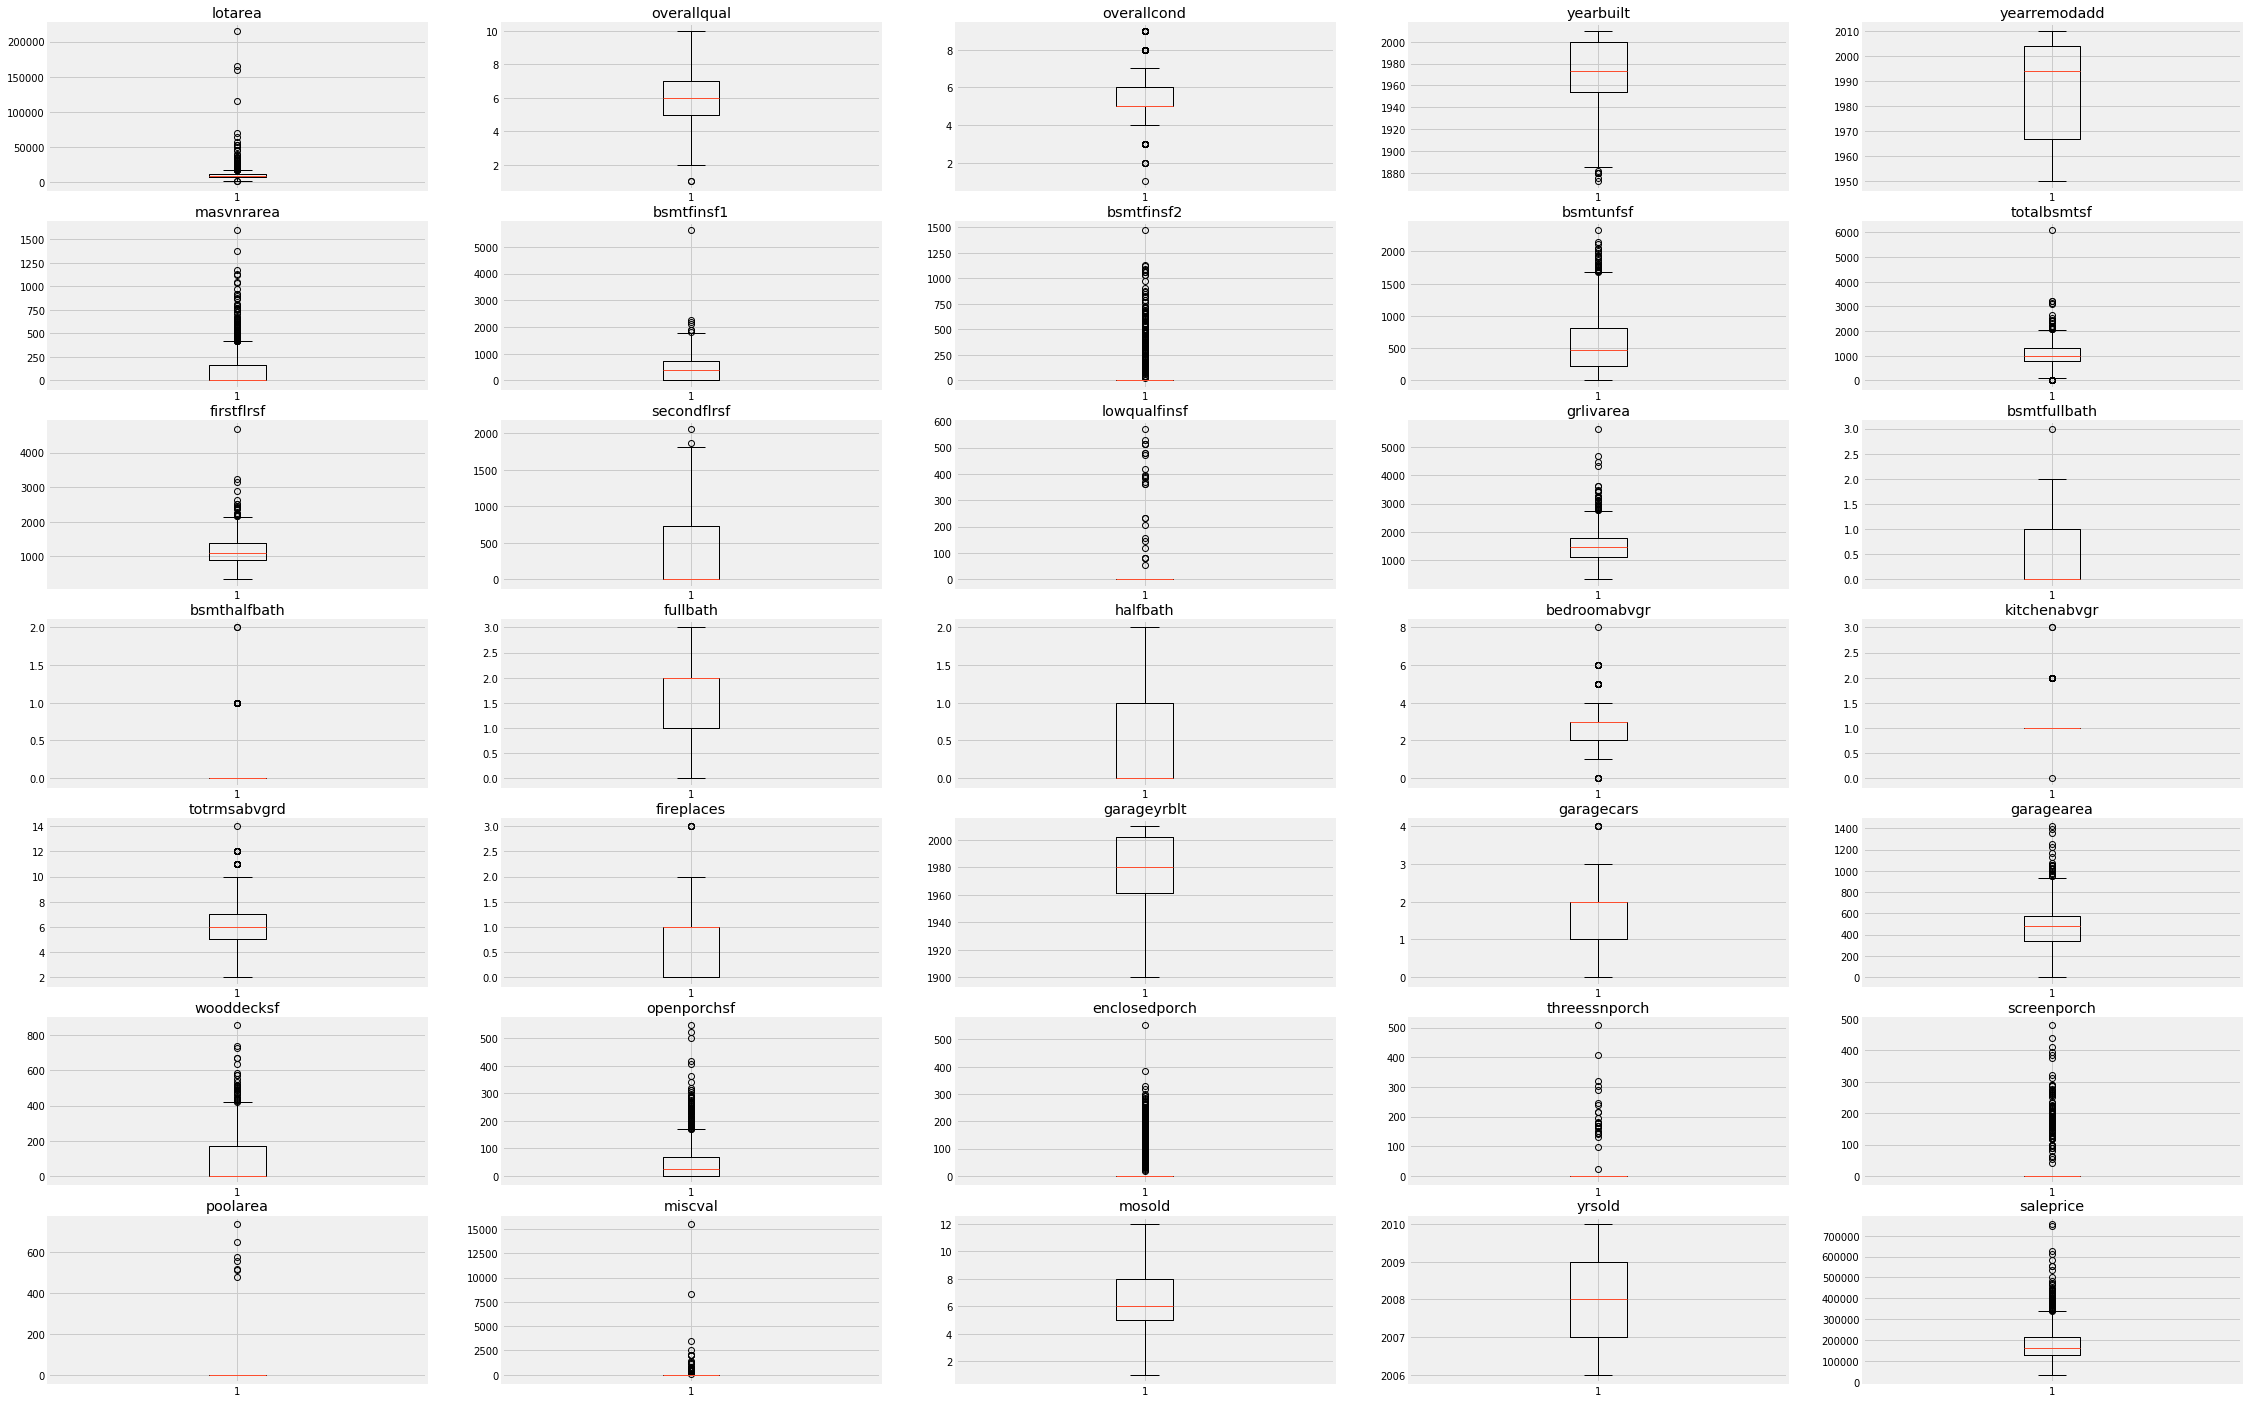

In [10]:
# Names of continuous variables
continuous_cols = df_train.drop("id", axis=1).select_dtypes(include=["number"]).columns

# Generate a boxplot for each variable
plt.figure(figsize=(35, 25))

i = 1
for col in continuous_cols:
    plt.subplot(7, 5, i)
    plt.boxplot(df[col].dropna())
    plt.title("{}".format(col))
    i += 1

plt.tight_layout
plt.show()

Most variables above have outliers. Like imputing or interpolating missing values, removing outliers or replacing them with "normal" values may change our distributions and therefore possibly the predictions. According to Alvira Swalin's [Medium article](https://heartbeat.fritz.ai/how-to-make-your-machine-learning-models-robust-to-outliers-44d404067d07), we should only drop outliers from measurement errors and if we worry about outliers biasing predictions, we can use modeling approaches (e.g., random forest) that are robust to outliers.

How do we spot measurement errors? We can transform raw values into $Z$-scores; exceptionally high (e.g., +10) or low (e.g., -10) $Z$-scores may indicate such errors. The `StandardScaler` function in scikit-learn allows us to perform $Z$-transformation easily.

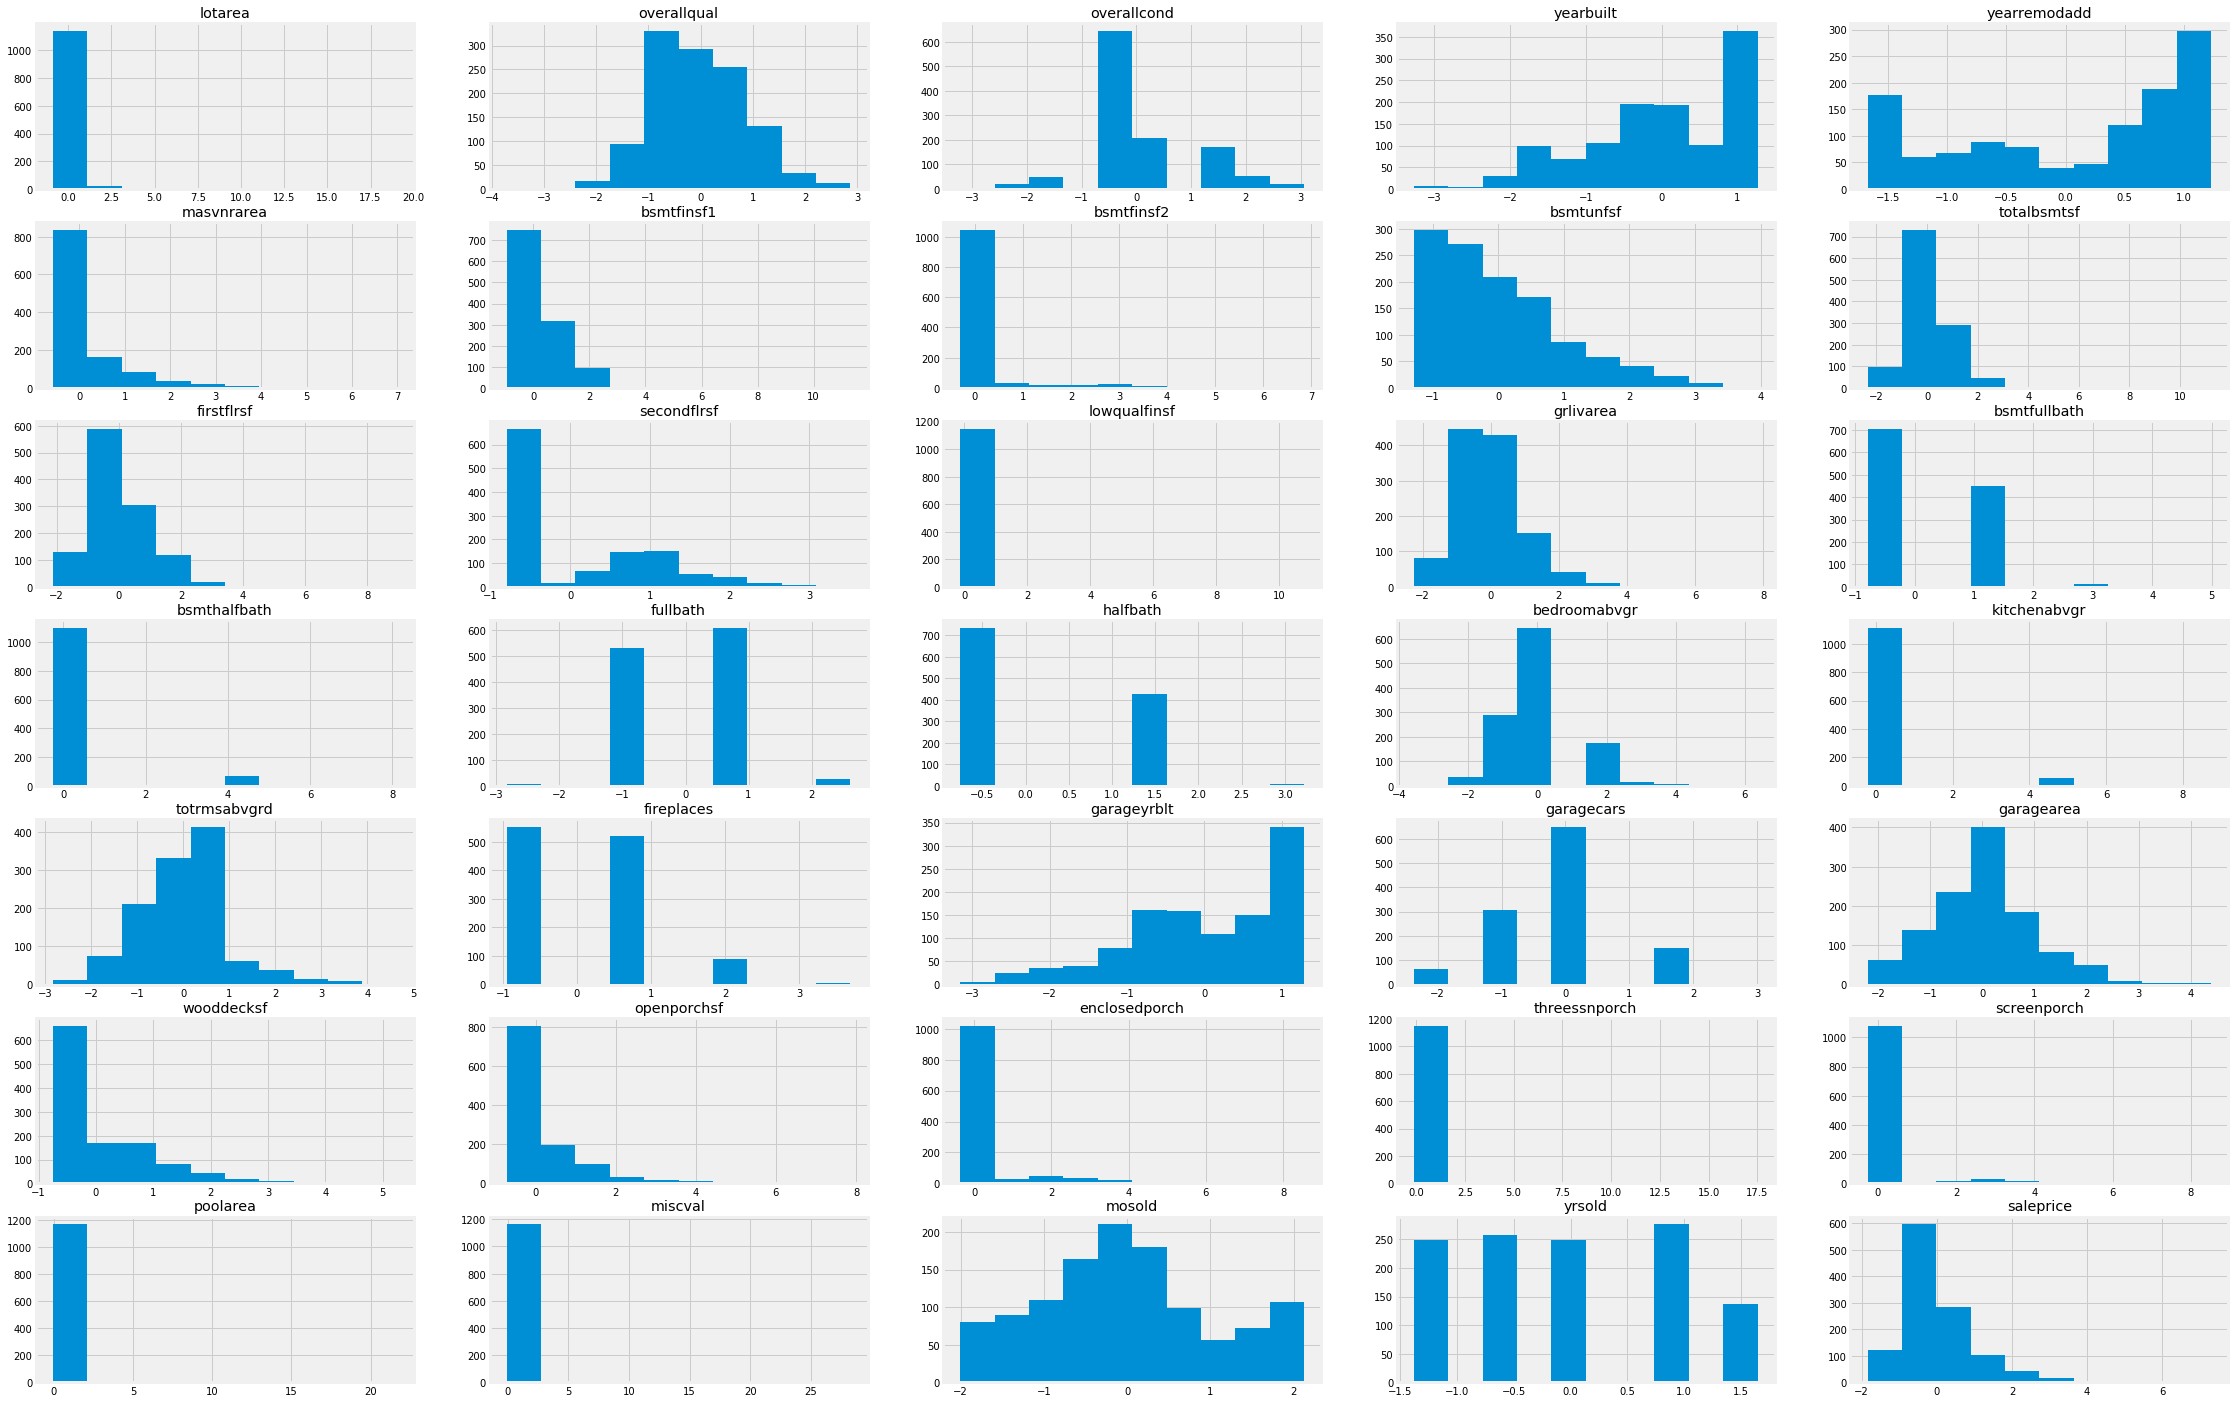

In [11]:
# Transform continuous variables
scaler = preprocessing.StandardScaler().fit(df_train[continuous_cols])

# Generate histograms of Z-scores
plt.figure(figsize=(35, 25))

for i in range(len(continuous_cols)):
    plt.subplot(7, 5, i + 1)
    plt.hist(scaler.transform(df_train[continuous_cols])[:, i])
    plt.title("{}".format(continuous_cols[i]))

plt.tight_layout
plt.show()

Traditionally, $Z-$scores greater than 3 or smaller than -3 are considered as outliers but the raw values are still likely to be valid observations. Removing surprising but correctly measured observations may not improve model predictions (see [discussions](https://stats.stackexchange.com/questions/298551/will-removing-outliers-improve-my-predictive-model) on this topic here).

However, $Z$-scores of "real data" are unlikely to be, say, as high as 20 or 30. For example, the variable "lotarea" has outrageous $Z$-values that go above 20. Can a house have a 215,245 square feet lot? Maybe, but such extreme values are more likely due to measurement errors (e.g., wrong units, said value was used to label missing values, incorrect decimal places, etc.). I'll remove values whose $Z$-score lie outside of $\pm 5$ as they might indicate measurement errors. This threshold should allow us to remove just the few extreme values without losing too many data points.

In [12]:
# Replace values whose absoluate Z score >= 5 with missing values
for col in continuous_cols:
    outliers = np.abs(stats.zscore(df_train[col])) >= 5
    df_train.loc[outliers, col] = np.nan

Now let's draw histograms of the new $Z$-transformed values with potential measurement errors excluded.

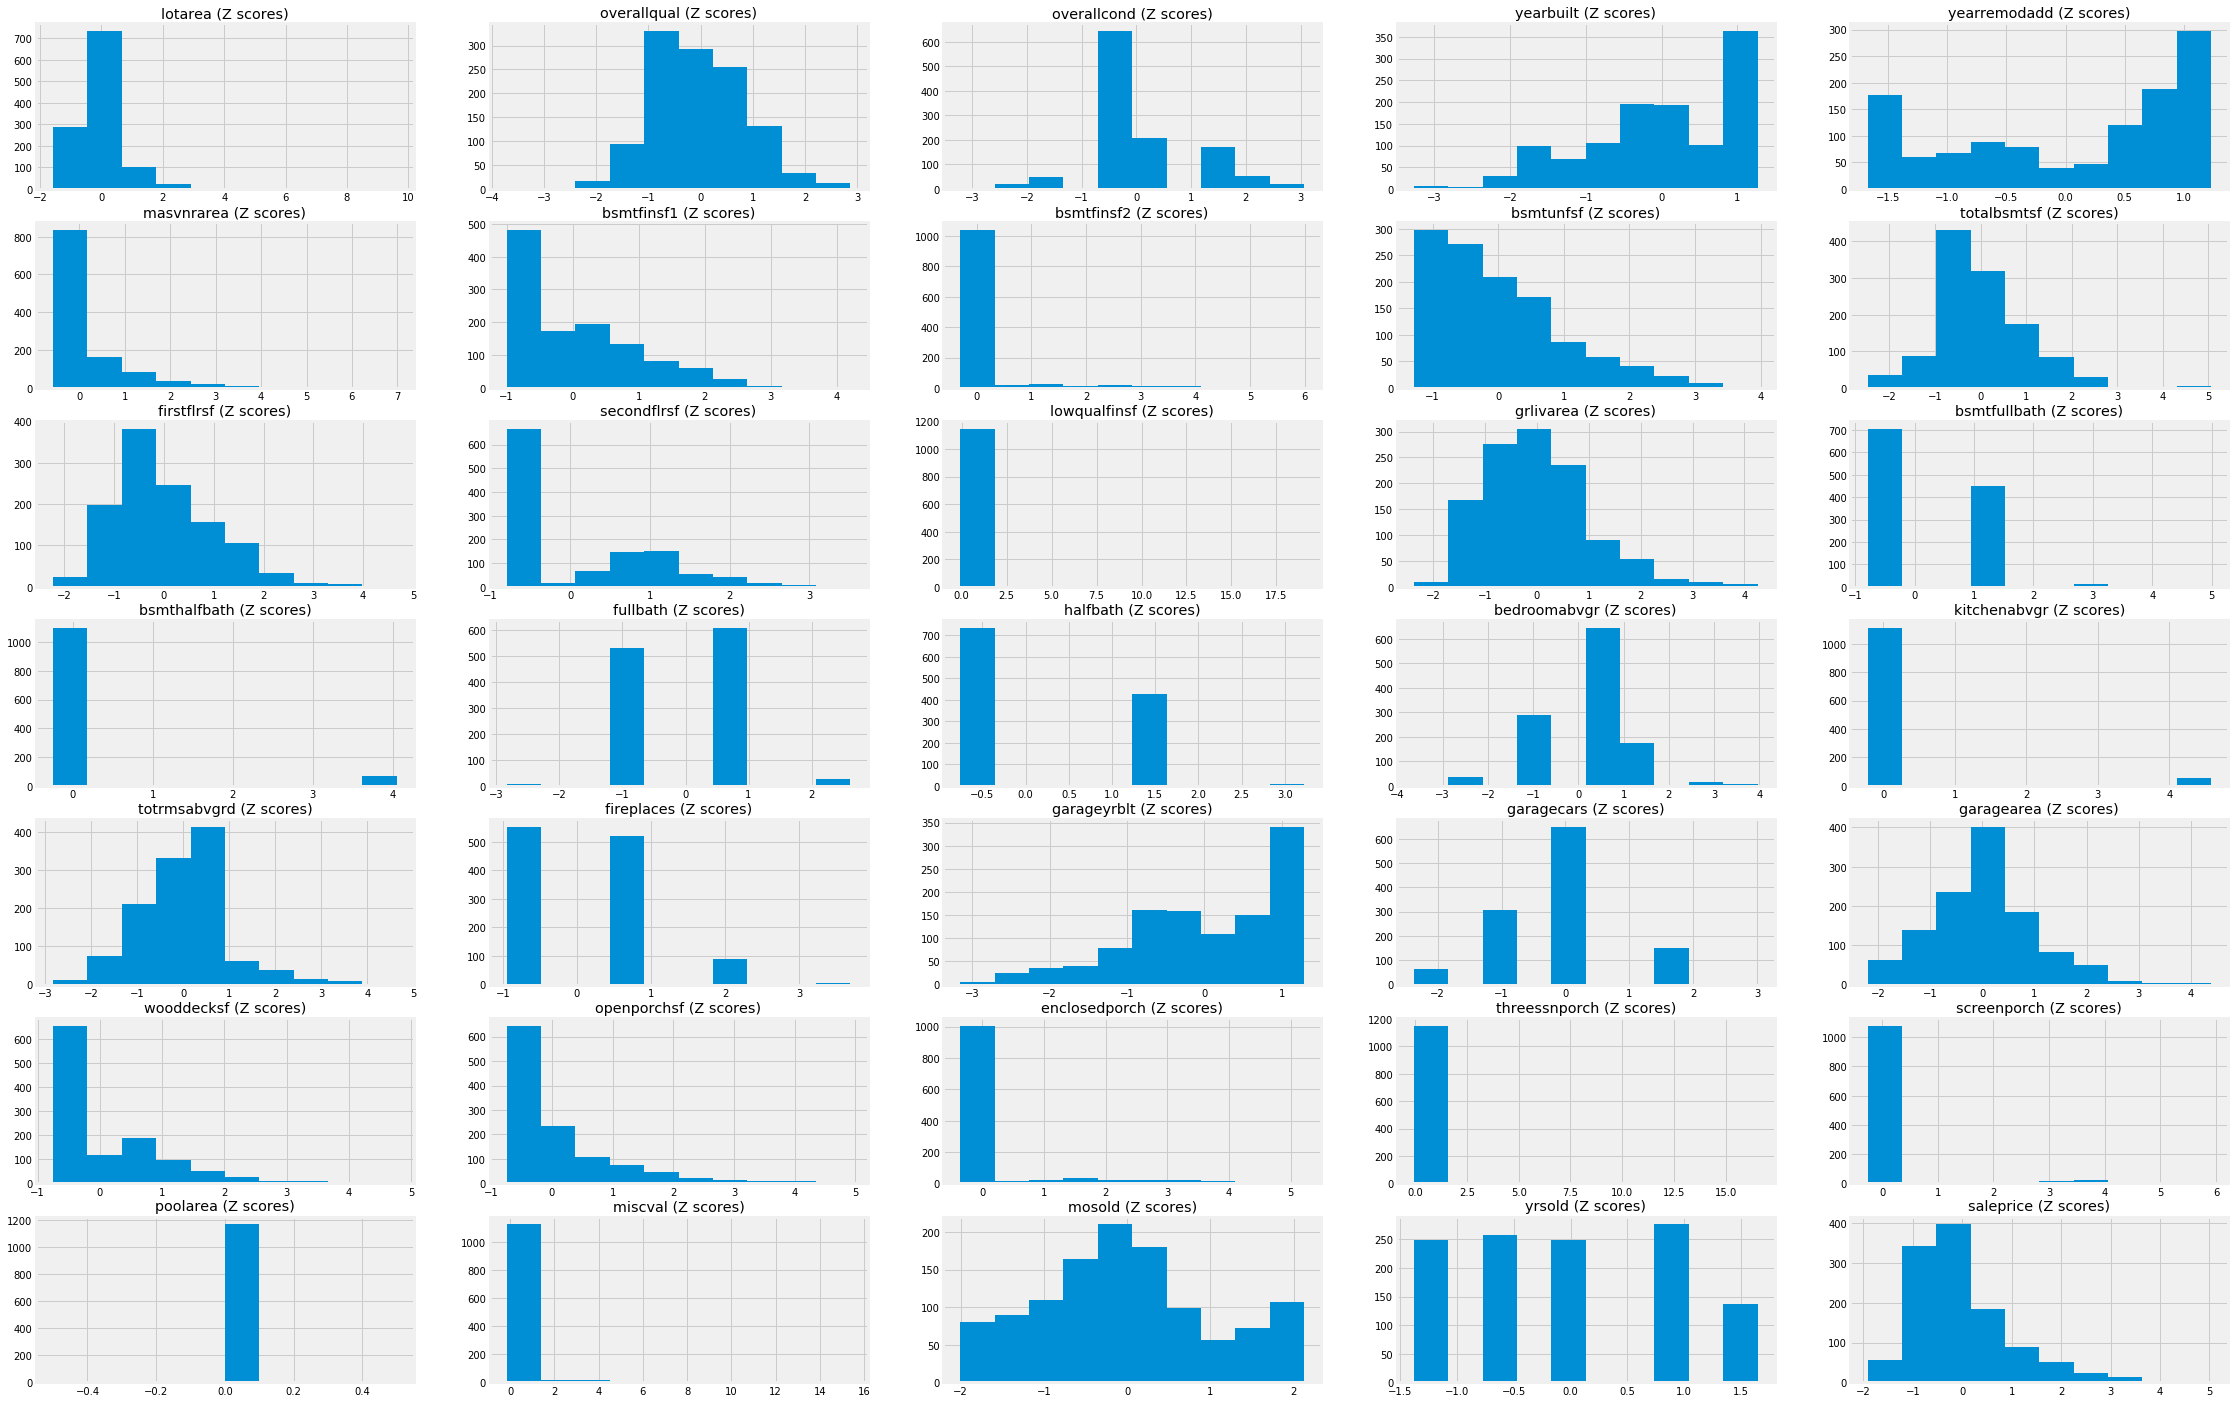

In [13]:
# Transform continuous variables
scaler = preprocessing.StandardScaler().fit(df_train[continuous_cols])

# Generate histograms of Z-scores
plt.figure(figsize=(35, 25))

for i in range(len(continuous_cols)):
    plt.subplot(7, 5, i + 1)
    plt.hist(scaler.transform(df_train[continuous_cols])[:, i])
    plt.title("{} (Z scores)".format(continuous_cols[i]))

plt.tight_layout
plt.show()

We can see that many extreme values are gone. Let's move on to explore relationships between variables.

### Data exploration

#### Univariate analysis
First of all, let's examine our target variable, "saleprice".

In [14]:
df_train["saleprice"].describe()

count      1165.000000
mean     179041.224893
std       75031.355895
min       35311.000000
25%      129900.000000
50%      162000.000000
75%      213000.000000
max      556581.000000
Name: saleprice, dtype: float64

The lowest house price is 35,111 and the highest is 556,581. So far nothing seems out of the ordinary.

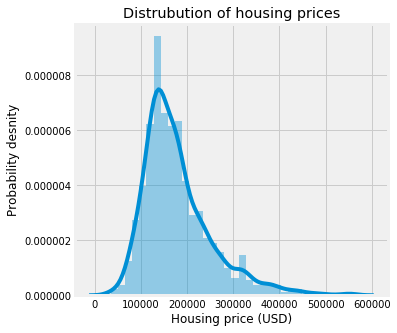

Skewness: 1.443106
Kurtosis: 2.882099


In [15]:
# Distribution of housing prices
plt.figure(figsize=(5, 5))

sns.distplot(df_train["saleprice"].dropna())
plt.xlabel("Housing price (USD)")
plt.ylabel("Probability desnity")
plt.title("Distrubution of housing prices")

plt.show()

# Kkewness and kurtosis of the distribution
print("Skewness: %f" % df_train["saleprice"].skew())
print("Kurtosis: %f" % df_train["saleprice"].kurt())

It's important for many models that the target variable is normally distributed. We can check normality using skewness and kurtosis. Skewness measures the asymmetry of a probability distribution and a value larger than 1 or smaller than -1 suggests that a distribution is highly skewed. And according to [Wikipedia](https://en.wikipedia.org/wiki/Kurtosis), Kurtosis measures the "tailedness" of a probability distribution and a value larger than 3 indicates that a distribution is heavy tailed. By both standards, the housing price distribution is not normal but rather right skewed.

Luckily, log transformation can normalize right-skewed distributions quite effectively (whereas it tends to make left-skewed distributions even more left skewed; see discussions [here](https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution)). We can create a new variable called "saleprice_log" to store the log transformed prices.

In [16]:
df_train["saleprice_log"] = np.log(df_train["saleprice"])

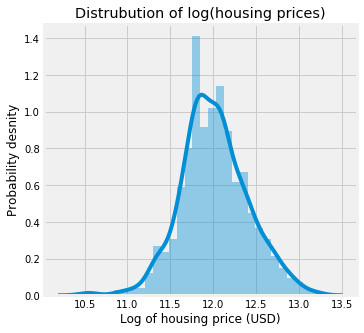

Skewness: 0.082920
Kurtosis: 0.567431


In [17]:
# Distribution of log(housing prices)
plt.figure(figsize=(5, 5))

sns.distplot(df_train["saleprice_log"].dropna())
plt.xlabel("Log of housing price (USD)")
plt.ylabel("Probability desnity")
plt.title("Distrubution of log(housing prices)")

plt.show()

# Skewness and kurtosis of the new distribution
print("Skewness: %f" % df_train["saleprice_log"].skew())
print("Kurtosis: %f" % df_train["saleprice_log"].kurt())

We can check that the new distribution is normally distributed. The old column can be dropped from the training data as it's no longer needed.

In [18]:
# Drop the raw sale prices
df_train.drop("saleprice", axis=1, inplace=True)

For other continuous values, we can similarly check for skweness and kurtosis.

In [19]:
for col in continuous_cols[:-1]:
    print(
        "{:15}".format(col),
        "Skewness: {:05.2f}".format(df_train[col].skew()),
        "   ",
        "Kurtosis: {:06.2f}".format(df_train[col].kurt()),
    )

lotarea         Skewness: 03.79     Kurtosis: 025.38
overallqual     Skewness: 00.27     Kurtosis: -00.02
overallcond     Skewness: 00.71     Kurtosis: 000.95
yearbuilt       Skewness: -0.59     Kurtosis: -00.47
yearremodadd    Skewness: -0.47     Kurtosis: -01.30
masvnrarea      Skewness: 02.52     Kurtosis: 008.18
bsmtfinsf1      Skewness: 00.79     Kurtosis: -00.09
bsmtfinsf2      Skewness: 03.71     Kurtosis: 013.61
bsmtunfsf       Skewness: 00.92     Kurtosis: 000.47
totalbsmtsf     Skewness: 00.65     Kurtosis: 002.25
firstflrsf      Skewness: 00.83     Kurtosis: 000.68
secondflrsf     Skewness: 00.80     Kurtosis: -00.62
lowqualfinsf    Skewness: 14.71     Kurtosis: 232.34
grlivarea       Skewness: 00.88     Kurtosis: 001.16
bsmtfullbath    Skewness: 00.70     Kurtosis: -00.61
bsmthalfbath    Skewness: 03.81     Kurtosis: 012.54
fullbath        Skewness: 00.08     Kurtosis: -00.89
halfbath        Skewness: 00.70     Kurtosis: -01.03
bedroomabvgr    Skewness: 00.08     Kurtosis: 

Quite a few variables are skewed and/or heavy tailed. Like before, we can log transform highly right-skewed distributions (skewness > 1) to normalize them and drop the old columns afterwards.

In [20]:
for col in continuous_cols[:-1]:
    if df_train[col].skew() > 1:
        df_train[col + "_log"] = np.log(df_train[col])
        df_train.drop(col, inplace=True, axis=1)

For discrete variables (not including "id"), we can check for class imbalance. Since we're building linear regression models rather than classification models, class imbalance isn't a huge problem if it's not too extreme (e.g., 10000:1, see [discussions](https://mathoverflow.net/questions/53541/how-to-construct-a-linear-regression-model-with-an-unbalanced-sample-design)).

In [21]:
# Names of discrete columns
discrete_cols = df_train.select_dtypes(include=["object"]).columns

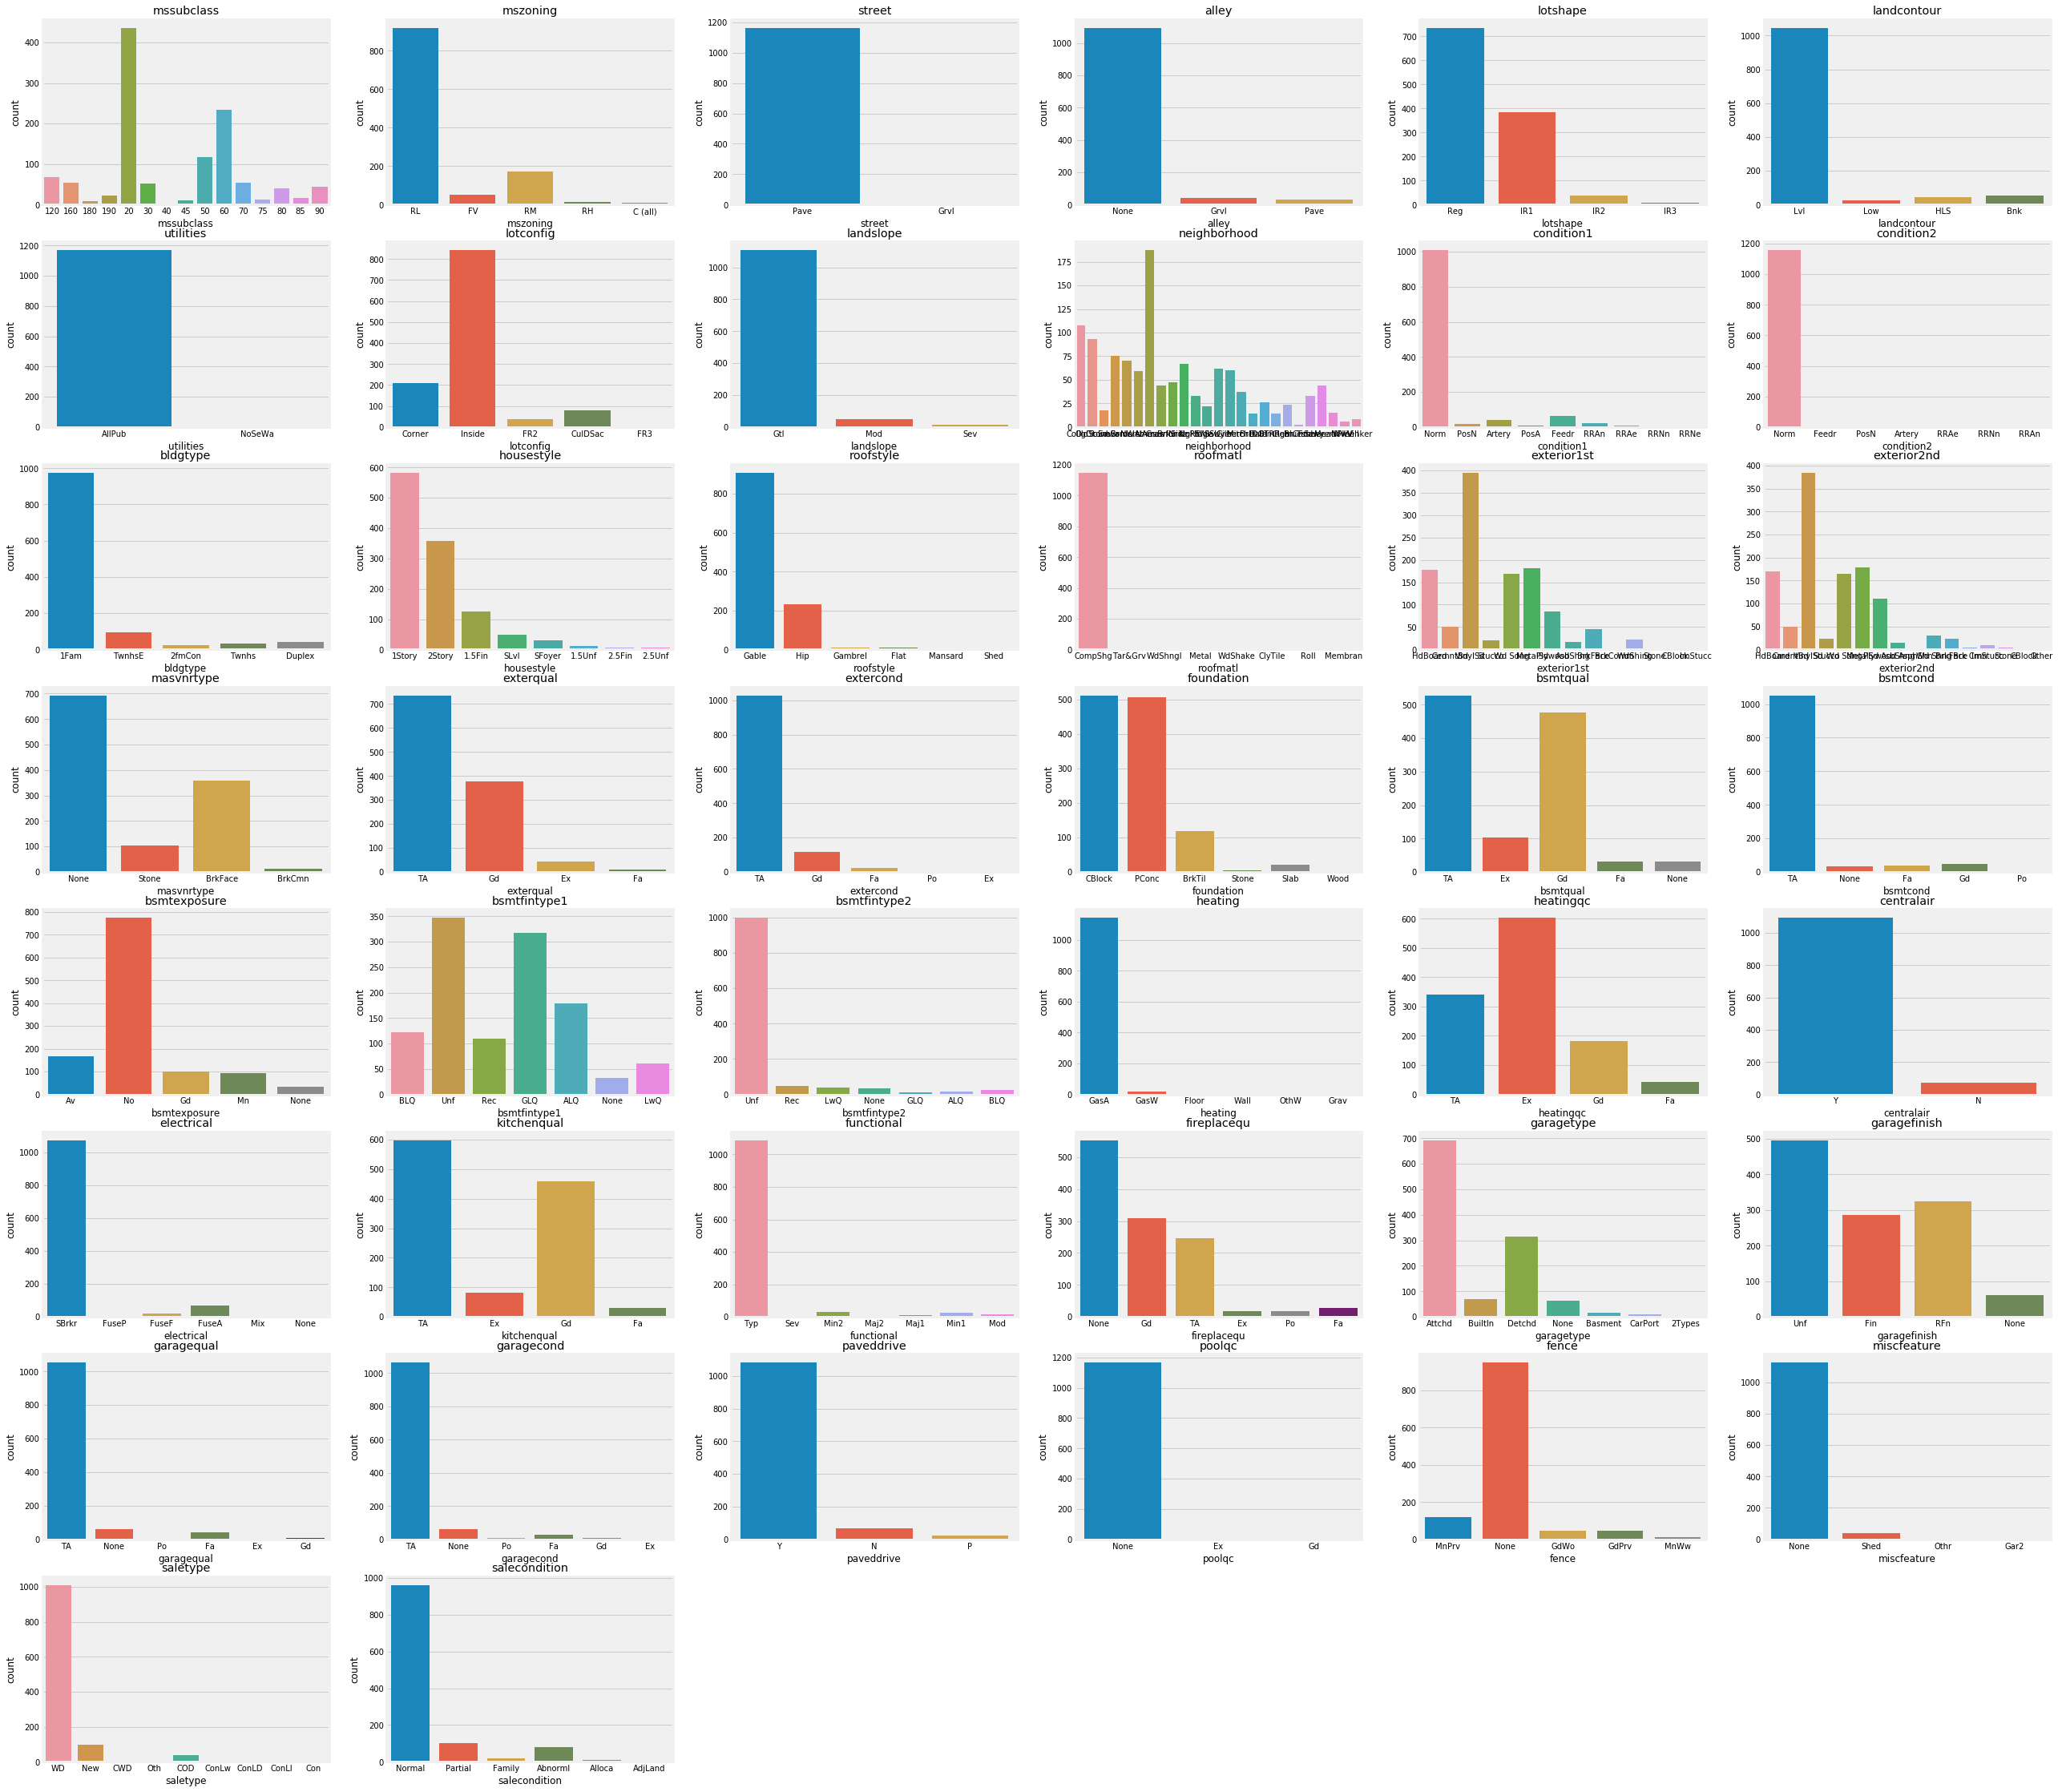

In [22]:
# Generate countplots for discrete variables
plt.figure(figsize=(40, 40))

i = 1
for col in discrete_cols:
    plt.subplot(8, 6, i)
    sns.countplot(x=col, data=df_train[discrete_cols])
    plt.title("{}".format(col))
    i += 1

plt.tight_layout
plt.show()

As we can see, while class imbalance is quite obvious in almost all cases, it's not considered too extreme for regression models.

#### Bivariate analysis 
First, let's examine the relationship between each continuous variable and our target variable, saleprice_log .

In [23]:
# Names of continuous columns
continuous_cols = df_train.drop("id", axis=1).select_dtypes(include=["number"]).columns

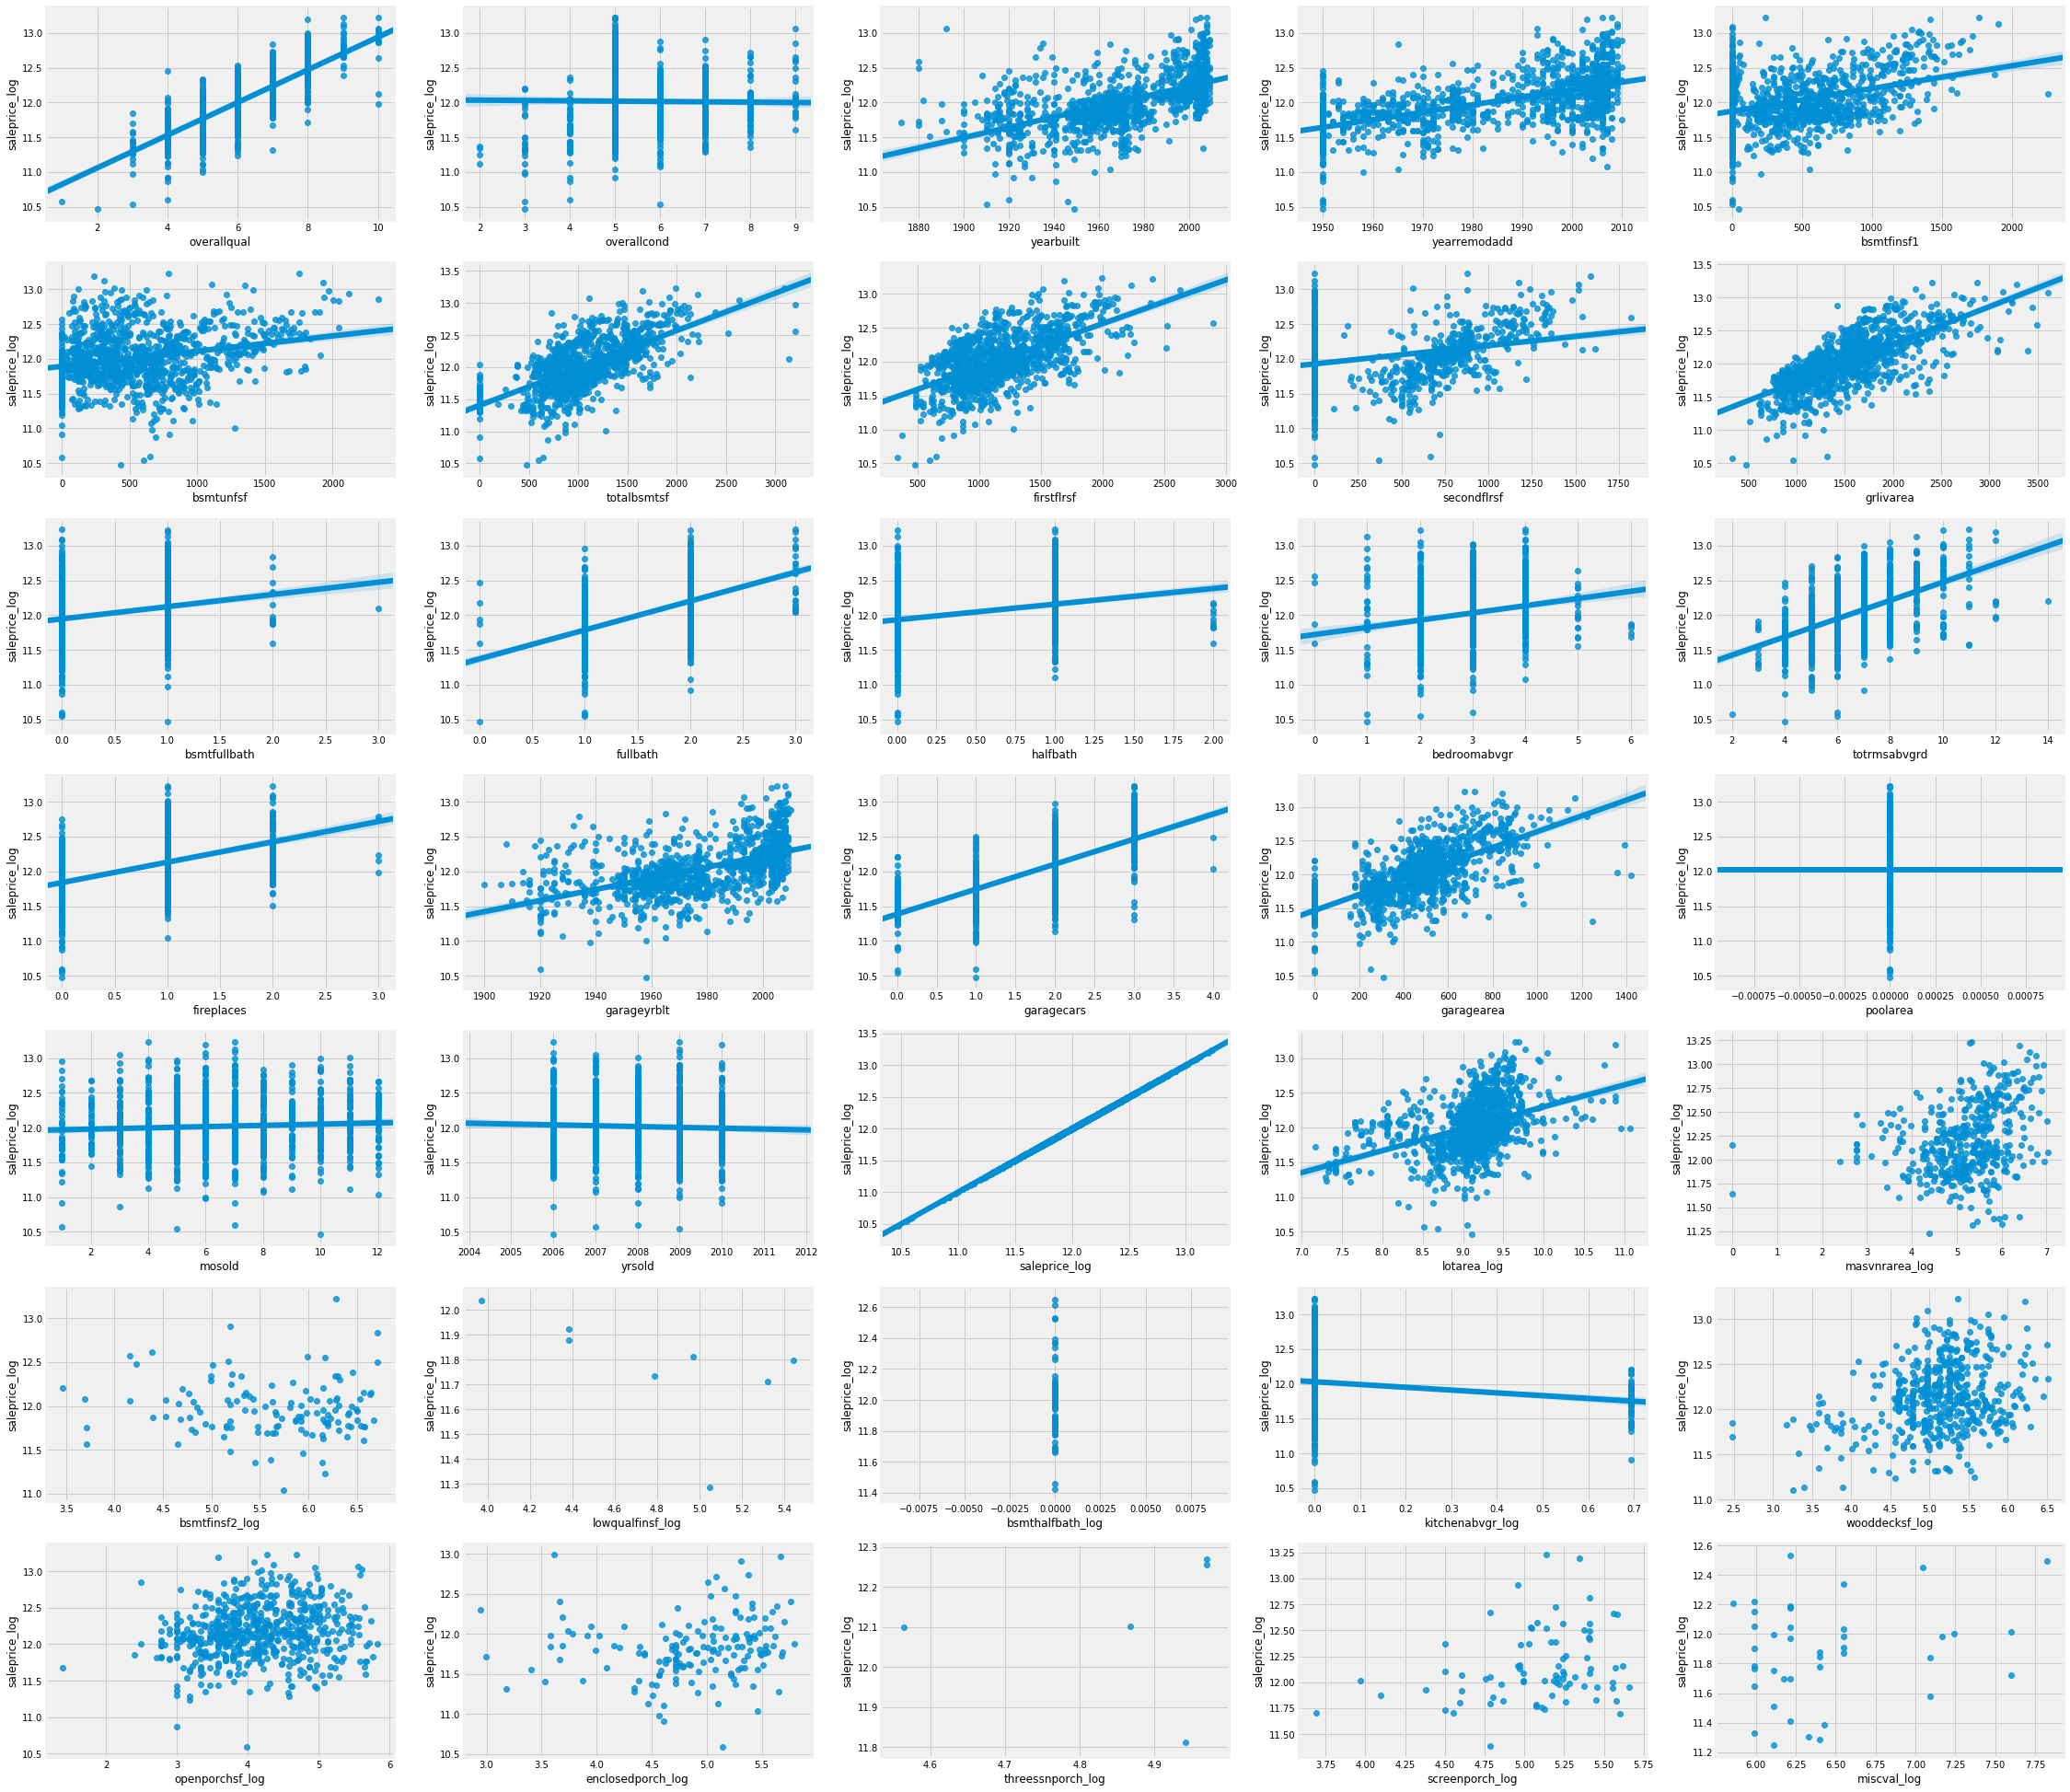

In [24]:
# Generate regression plots
plt.figure(figsize=(35, 35))

i = 1
for col in continuous_cols:
    plt.subplot(7, 5, i)
    sns.regplot(x=col, y="saleprice_log", data=df_train[continuous_cols], fit_reg=True)
    i += 1

plt.tight_layout
plt.show()

Some variables are strongly correlated with saleprice_log, such as "overallqual" (rates the overall material and finish of the house) and "grlivarea" (above ground living area square feet). Some variables such as "mosold", "yrsold", etc. don't seem to have much influence on sale prices. Even worse, there are variables (e.g., "threessnporch", "poolarea") whose values are largely fixed and can't possibly be used as predictors. We can exclude weakly correlated or invariant variables by imposing a threshold on correlation coefficients (e.g., r >= 0.2).

In [25]:
# Set the threshold to be r = 0.2
thresh = 0.2

# Compute pairwise correlations
corr = df_train[continuous_cols].corr()

# Absolute values of correlation coefficients
corr_abs = corr.abs()

# Correlations with target variable, ranked
corr_target = corr_abs.nlargest(len(continuous_cols), "saleprice_log")["saleprice_log"]

# Drop variables with weak correlations
below_continuous = list(corr_target[corr_target.values < thresh].index)
above_continuous = list(corr_target[corr_target.values >= thresh].index)

df_train = df_train.drop(below_continuous, axis=1)

Out of caution, let's check if all continuous variables are included in the calculation.

In [26]:
print(
    "{} variables above or below the threshold.".format(
        len(above_continuous) + len(below_continuous)
    )
)

print("There are {} continuous variables in total.".format(len(continuous_cols)))

33 variables above or below the threshold.
There are 35 continuous variables in total.


The two missing variables are "poolarea" and "bsmthalfbath_log", both of which which are invariant and should be excluded.

In [27]:
df_train = df_train.drop(["poolarea", "bsmthalfbath_log"], axis=1)

For discrete variables, we can use box plots to check if saleprice_log differs by category.

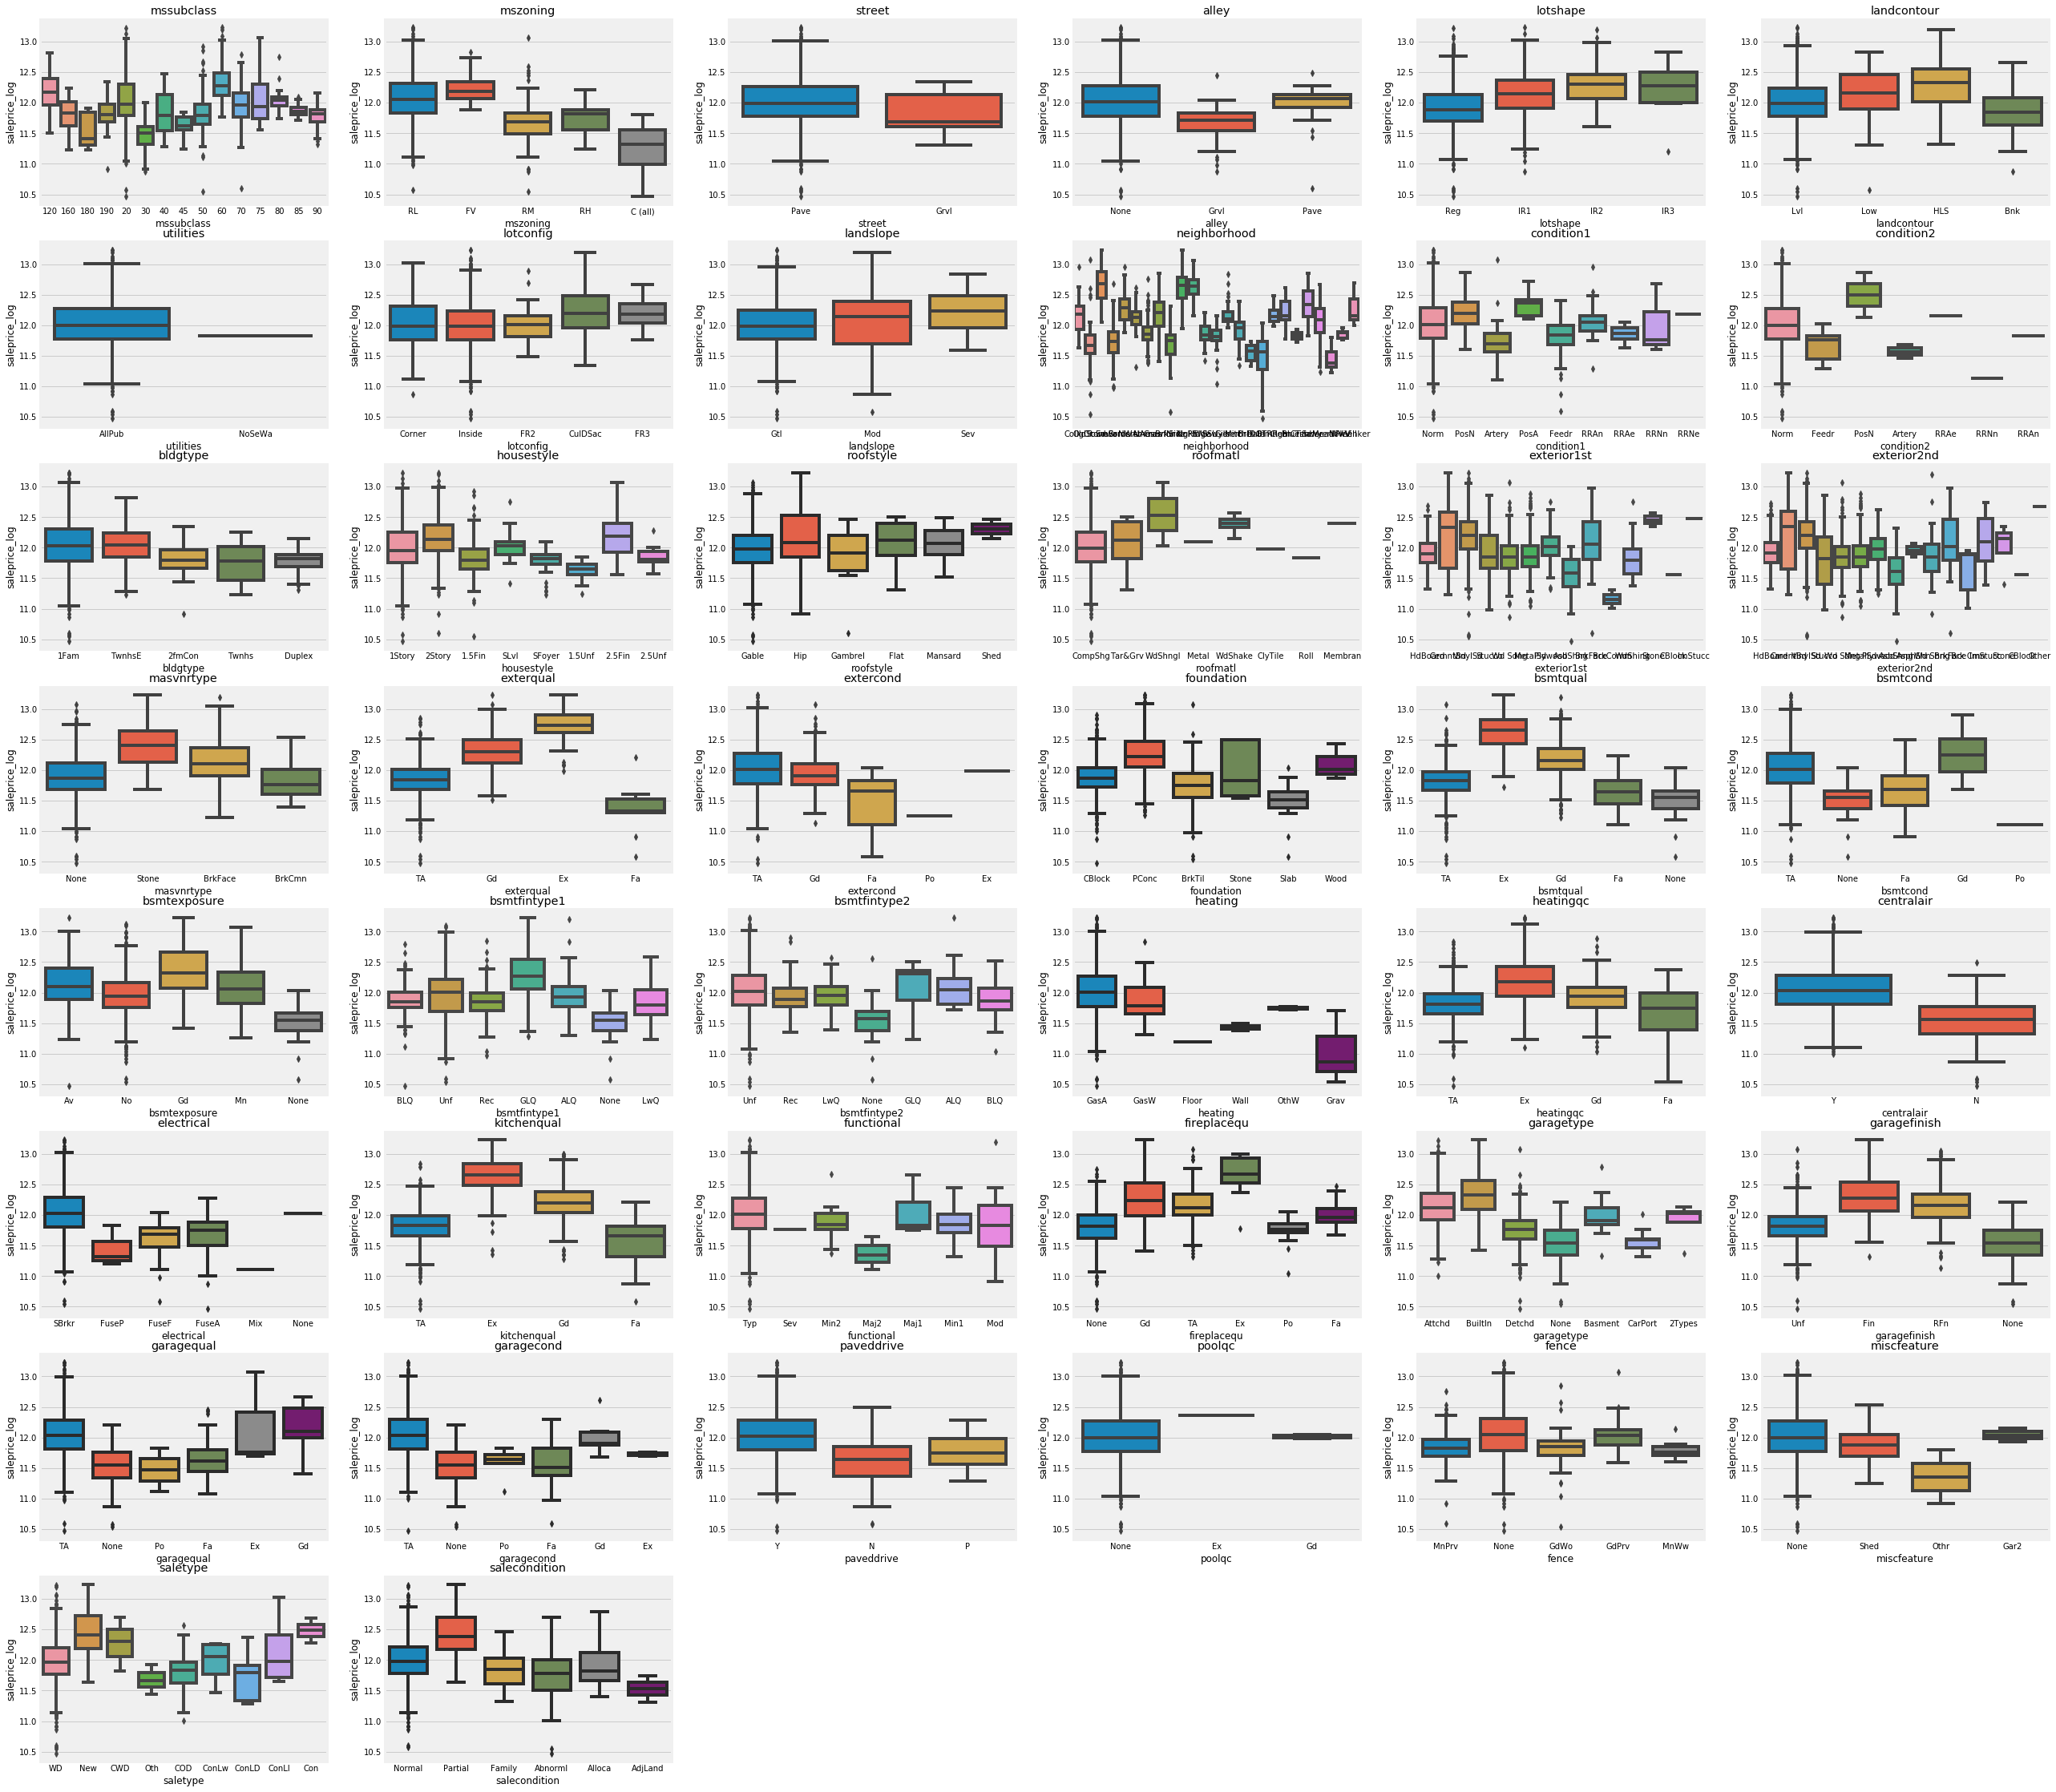

In [28]:
# Generate countplots for discrete variables
plt.figure(figsize=(40, 40))

i = 1
for col in discrete_cols:
    plt.subplot(8, 6, i)
    sns.boxplot(
        x=col,
        y="saleprice_log",
        data=df_train[discrete_cols.tolist() + ["saleprice_log"]],
    )
    plt.title("{}".format(col))
    i += 1

plt.tight_layout
plt.show()

Some variables (e.g., "mszoning", "salecondition") seem to have strong influence on house prices while others (e.g., "lotconfig") barely do. To filter out variables with little impact on house prices in a more precious manner, we can assign a numeric value to each category using [label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) (each category is assigned a unique number ranging from 0 to the number of classes - 1) and examine how well each variable correlates with saleprice_log. 

Granted, label encoding creates ordinality that doesn't exist in our nominal data. For example, gravel roads aren't larger than paved roads, even though the former are assign 1 and the latter 0. As long as we don't interpret data in an ordinal manner, we can use label encoding to calculate correlations and select features. By contrast, [one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) creates one variable for each category and blows up feature dimensions quickly.

In [29]:
# Label encode categorical variables
le = preprocessing.LabelEncoder()

for col in discrete_cols:
    le.fit(df_train[col])
    df_train[col + "_num"] = le.transform(df_train[col])
    df_train.drop(col, axis=1, inplace=True)

# Names of new columns
new_cols = [col + "_num" for col in discrete_cols]

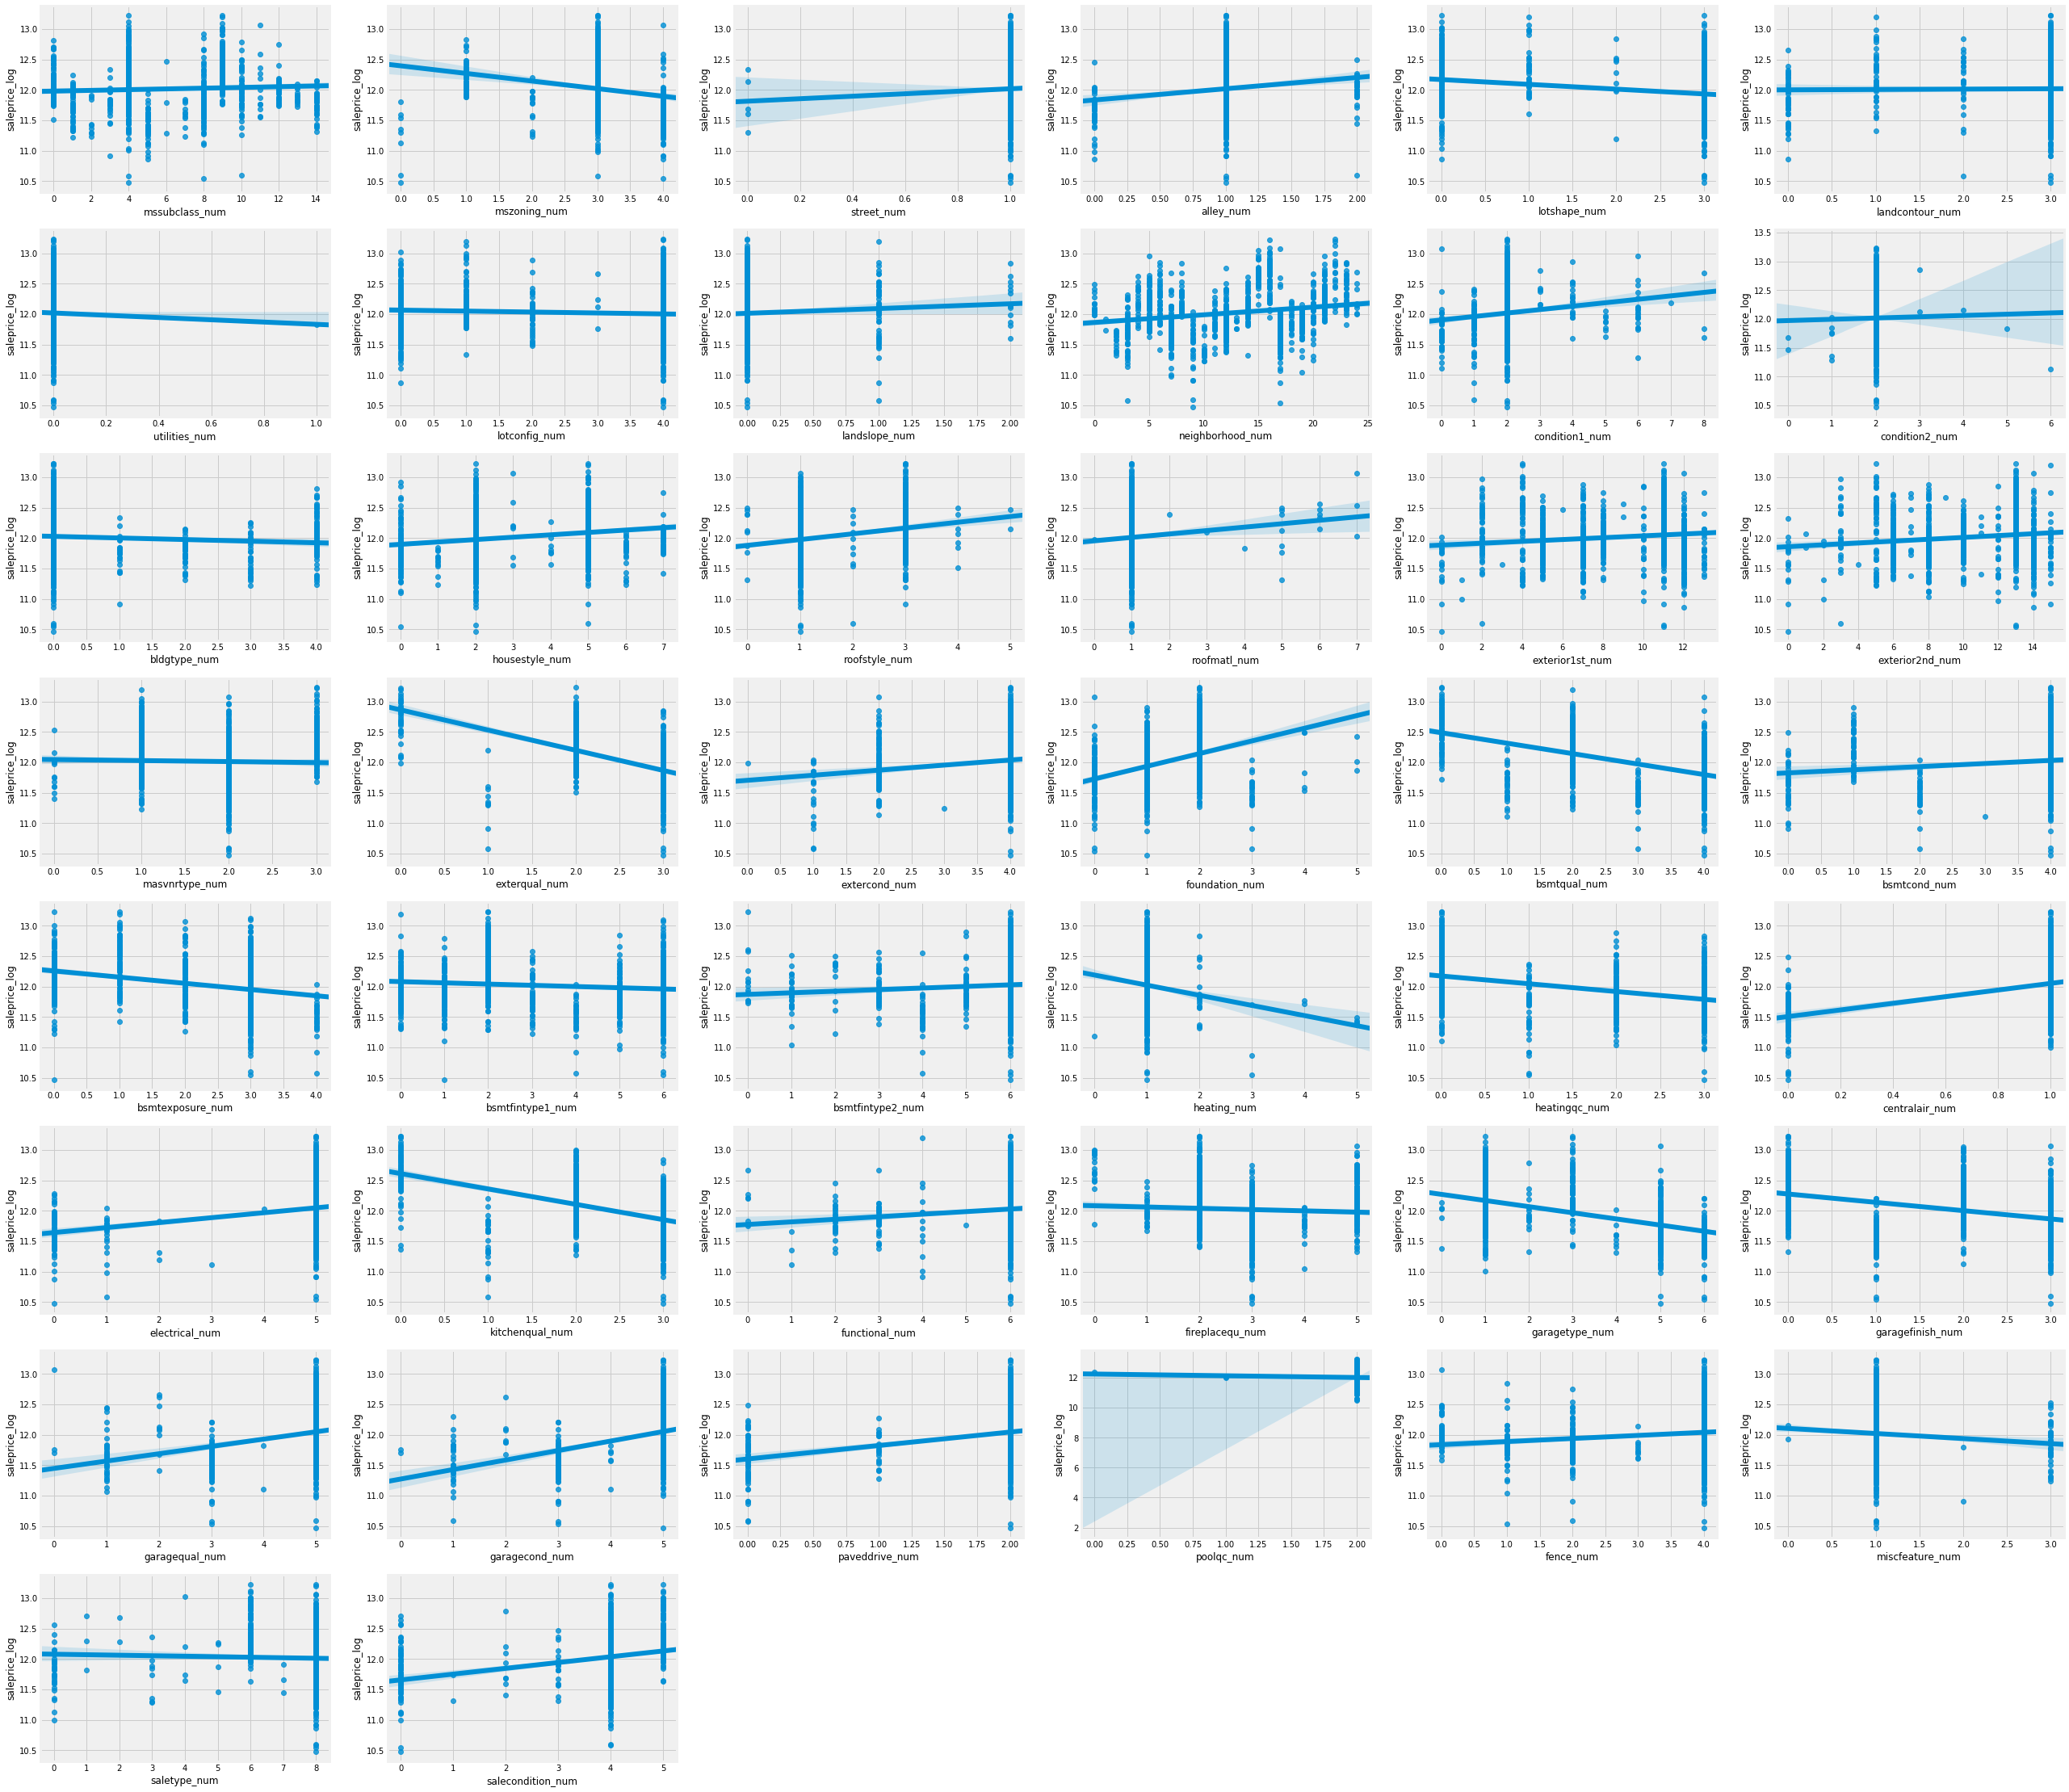

In [30]:
# Generate regression plots
plt.figure(figsize=(40, 40))

i = 1
for col in new_cols:
    plt.subplot(8, 6, i)
    sns.regplot(x=col, y="saleprice_log", data=df_train, fit_reg=True)
    i += 1

plt.tight_layout
plt.show()

Like before, we can drop variables that are only weakly correlated (r < 0.2) with saleprice_log.

In [31]:
# Set the threshold to be r = 0.2
thresh = 0.2

# Compute pairwise correlations
corr = df_train[new_cols + ["saleprice_log"]].corr()

# Absolute values of correlation coefficients
corr_abs = corr.abs()

# Correlations with target variable, ranked
corr_target = corr_abs.nlargest(len(new_cols) + 1, "saleprice_log")["saleprice_log"]

# Drop variables with weak correlations
below_discrete = list(corr_target[corr_target.values < thresh].index)
above_discrete = list(corr_target[corr_target.values >= thresh].index)

df_train = df_train.drop(below_discrete, axis=1)

In [32]:
# Shape of current data
df_train.drop("id", axis=1).shape

(1168, 42)

After dropping variables that are weakly correlated with saleprice_log, we still have 41 left (not including the target). Even though each variable is somewhat correlated with the target, we may not need every single one of them. For instance, if we've already included the total living area above ground, we may not need the area of each floor. Next, I'll select variables that may have unique contributions to our regression models.

### Feature engineering
Not all variables are useful features for predicting house prices. Selecting the right features is essential for building successful models. Ideally, we want to find features that are highly correlated with the target variable and distinct from each other. How can we achieve this? As Abhini Shetye summarized in her [Medium article](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b), there are 3 common methods: filter methods, wrapper methods, and embedded methods. 

But first off, let's examine the relationships among the remaining variables.

#### Correlation matrix
We can do so by generating a heat map of the correlation matrix of all the variables.

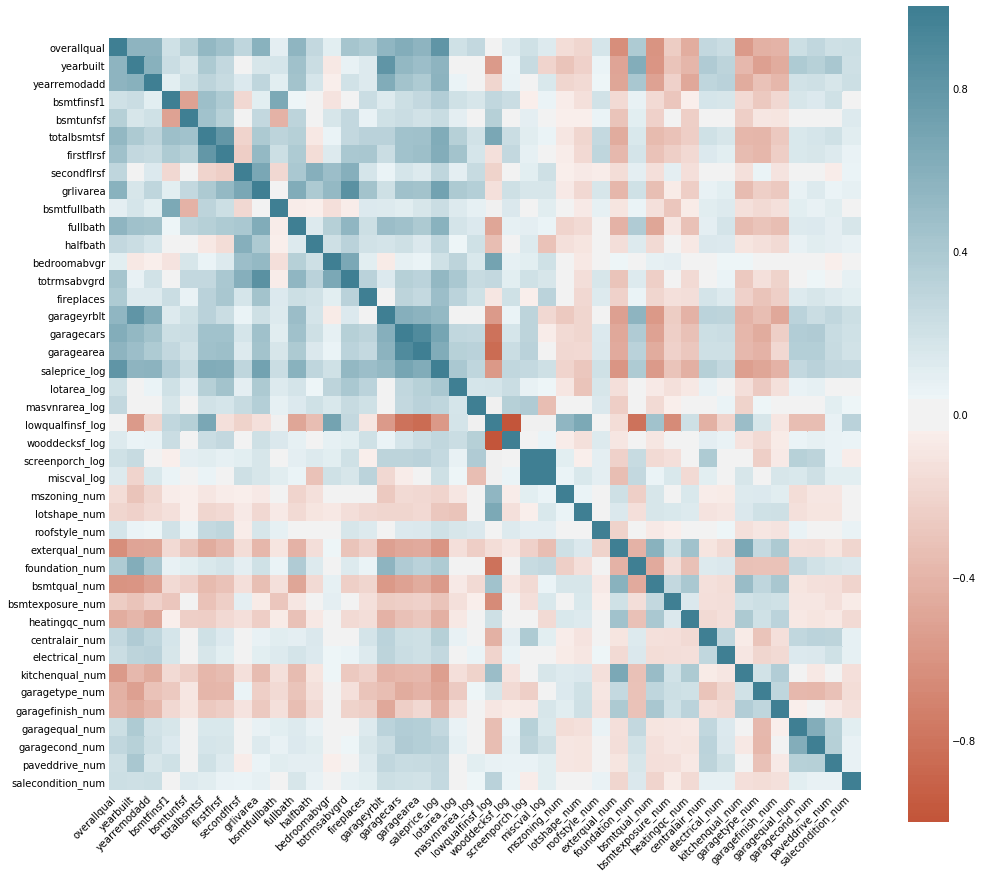

In [33]:
# Correlation matrix of all 21 variables
corr = df_train.drop("id", axis=1).corr()

# Plot Pearson correaltion coefficients on a heat map
plt.figure(figsize=(15, 15))

ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

plt.show()

#### Filter methods

Using the filter method, we can drop features that are weakly correlated with the target. This time, we can set a stricter threshold of r >= 0.5.

In [34]:
# Correlations with target variable
cor_target = abs(corr["saleprice_log"])

# Selecting highly correlated features
relevant_features = cor_target[cor_target >= 0.5]

print(
    "{} features are highly correlated (r >= 0.5) with saleprice_log.".format(
        len(relevant_features)
    )
)

16 features are highly correlated (r >= 0.5) with saleprice_log.


Another concern is that some features are highly correlated with one another, a notable case being "yearbuilt" and "garageyrblt". This is understandable since a house is usually built at the same time as its garage. We need only keep one of several features that are highly correlated.

In [35]:
# Correlation matrix of revelant feature
relevant_corr = corr[relevant_features.index.tolist()]

# Select upper triangle of the new correlation matrix
upper = relevant_corr.where(np.triu(np.ones(relevant_corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [col for col in upper.columns if any(upper[col] > 0.8)]

print("The redudant features are: {}.".format(to_drop))

The redudant features are: ['garageyrblt', 'saleprice_log'].


Of course saleprice_log is prefectly correlated with itself. Among the explanatory variables, only "garageyrblt" is highly correlated with other features and therefore not worth keeping. Below is the list of 14 best features according to Pearson correlations.

In [36]:
# Features highly correlated with target and distinct from one another
features_list = relevant_features.index.drop(to_drop).tolist()

print(
    "{} features ({}) can be used to predict housing prices.".format(
        len(features_list), features_list
    )
)

14 features (['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf', 'firstflrsf', 'grlivarea', 'fullbath', 'totrmsabvgrd', 'garagecars', 'garagearea', 'lowqualfinsf_log', 'exterqual_num', 'bsmtqual_num', 'kitchenqual_num']) can be used to predict housing prices.


Filtering by Pearson correlations is fast but imprecise. Let's check out wrapper and embedded methods next.

#### Wrapper methods
Common wrapper methods include backward elimination that iteratively removes the worst performing features and recursive feature elimination (RFE) that keeps a required number of features. Backward elimination is simple but statisticians often [argue against](https://statmodeling.stat.columbia.edu/2014/06/02/hate-stepwise-regression/) such stepwise selection because it uses unconstrained least squares to calculate model fit, which can be problematic. RFE asks for a fixed number of features, which isn't what we want here.

Because of these shortcomings, I won't use wrapper methods for feature selection.

#### Embedded methods
Lasso regularization is considered one of the best methods for feature selection. It penalizes the coefficients of irrelevant features. If a feature's coefficient is 0, it will be removed from the feature list. Let's get back to the fuller set of 41 features and perform Lasso regularization.

Like many methods, Lasso cannot handle infinity or missing values, so we need to deal with them first.

In [37]:
# Replace infinity with missing values
df_train = df_train.replace([np.inf, -np.inf], np.nan)

# Find columns with missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(
    ascending=False
)
missing = pd.concat([total, percent], axis=1, keys=["total", "percent"])
missing = missing.loc[missing["total"] > 0, :]

missing

,total,percent
lowqualfinsf_log,1160,0.993151
miscval_log,1128,0.965753
screenporch_log,1087,0.930651
masvnrarea_log,691,0.591610
wooddecksf_log,622,0.532534
garageyrblt,62,0.053082
lotarea_log,4,0.003425
grlivarea,3,0.002568
saleprice_log,3,0.002568
firstflrsf,3,0.002568


Since "lowqualfinsf_log", "miscval_log", "screenporch_log", "masvnrarea_log", and "wooddecksf_log" are largely missing, we can drop them.

In [38]:
df_train = df_train.drop(
    [
        "lowqualfinsf_log",
        "miscval_log",
        "screenporch_log",
        "masvnrarea_log",
        "wooddecksf_log",
    ],
    axis=1,
)

Since there are only a few missing values, we can remove rows with missing values without losing much power.

In [39]:
df_train = df_train.dropna()

Perform Lasso regression on the new data frame.

In [40]:
# Target vector
y = df_train["saleprice_log"]

# Feature vectors
X = df_train.drop("id", axis=1).loc[
    :, df_train.drop("id", axis=1).columns != "saleprice_log"
]

# Lasso regularization
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(X, y))
coef = pd.Series(reg.coef_, index=X.columns)

Best alpha using built-in LassoCV: 0.129655
Best score using built-in LassoCV: 0.821313


Which features are picked by Lasso and which ones are eliminated? Let's plot out features by importance.

Lasso picked 9 variables and eliminated the other 27 variables


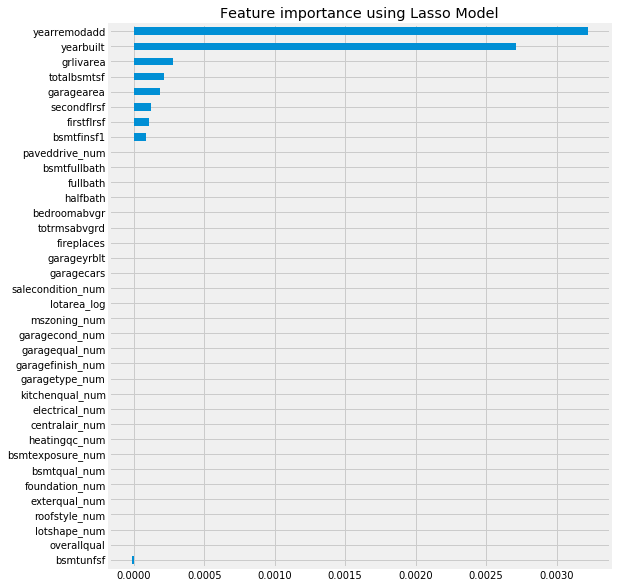

In [41]:
# Number of features picked and eliminated
print(
    "Lasso picked "
    + str(sum(coef != 0))
    + " variables and eliminated the other "
    + str(sum(coef == 0))
    + " variables"
)

# Plot feature importance
imp_coef = coef.sort_values()
import matplotlib

matplotlib.rcParams["figure.figsize"] = (8.0, 10.0)
imp_coef.plot(kind="barh")
plt.title("Feature importance using Lasso Model")

plt.show()

Most features are deemed unimportant by Lasso, except for "yearremodadd", "yearbuilt", "grlivarea", "totalbsmtsf", "garagearea", "secondflrsf", "firstlfrsf", and "bsmtfinsf1". 

## Regression models

Finally, we can use the above features to predict house prices! Let's try and compare different regression methods.

In [42]:
features_final = [
    "yearremodadd",
    "yearbuilt",
    "grlivarea",
    "totalbsmtsf",
    "garagearea",
    "secondflrsf",
    "firstflrsf",
    "bsmtfinsf1",
]

### Linear regression
To begin, we can fit a simple linear regression model using `LinearRegression()` in scikit-learn.

#### Train model

In [43]:
# Target variable
y = df_train["saleprice_log"]

# Feature vectors
X = df_train[features_final]

# Create a LinearRegression model object
lrm = LinearRegression()

# Estimate coefficients using OLS
lrm.fit(X, y)

# Display results
print("\nCoefficients: \n", lrm.coef_)
print("\nIntercept: \n", lrm.intercept_)


Coefficients: 
 [0.00352865 0.00277247 0.00026181 0.00019927 0.00017153 0.0001345
 0.0001193  0.00010182]

Intercept: 
 -1.3548171603548376


#### Cross validation
We can use $k$-fold cross validation to check model performance, especially to guard against overfitting. To do so, we will split the training data into $k$ groups and, in turn, use each group as the test dataset to evaluate the model trained on the other ($k-1$) groups. A popular choice of $k$ is 10. 

The `cross_val_score` module in scikit-learn implements this process easily. We can specify different evaluation [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html), such as mean absolute error (MAE), mean squared error (MSE), root mean squared error (RMSE), mean absolute percentage error (MAPE), etc.. RMSE is the most commonly used metric to evaluate predictive models. By definition, RMSE is the square root of the variance of residuals and lower values indicate better fit. 

In [44]:
scores = cross_val_score(lrm, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print(
    "For linear regression: RMSE of each fold is {} and the mean is {}.".format(
        rmse_scores, rmse_scores.mean()
    )
)

For linear regression: RMSE of each fold is [0.1691827  0.15861262 0.1527591  0.1634695  0.15848977 0.1664101
 0.16080265 0.15535779 0.15598346 0.16037259] and the mean is 0.16014402692195556.


### Regularized regression

To prevent overfitting, we can apply [regularization techniques](https://towardsdatascience.com/over-fitting-and-regularization-64d16100f45c?) where we discourage model complexity by penalizing the loss function. Different techniques have different penalty terms. L1 regularization like Lasso regression penalizes the absolute value of feature weights. L2 regularization like Ridge regression penalizes the sum of square of all feature weights. ElasticNet regression is a hybrid of Lasso and Ridge and usually does a better job at preventing overfitting. We can fit our house price data using each of these techniques.

#### Hyperparameter tuning
All the regularized regression models have hyperparameters. Lasso and Ridge have one hyperparameter $\alpha$ that controls the amount of regularization: The larger the $\alpha$, the more feature coefficients are 0. ElasticNet regression additionally have a hyperparameter "L1 ratio" controlling the weights of L1 and L2 regressions; when equal to 1, ElasticNet regression becomes Lasso. Before fitting models, let's find the best hyperparameters to use.

In [45]:
# Use K-fold cross validation to select hyperparameters
lasso_cv = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0])

ridge_cv = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])


elastic_cv = ElasticNetCV(
    eps=None,
    n_alphas=None,
    alphas=[0.01, 0.1, 1.0, 10.0],
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    cv=5,
)


print("The best alpha for Lasso is {}.\n".format(lasso_cv.fit(X, y).alpha_))

print("The best alpha for Ridge is {}.\n".format(ridge_cv.fit(X, y).alpha_))

print(
    "The best alpha for ElasticNet is {} and the best l1_ratio is {}.".format(
        elastic_cv.fit(X, y).alpha_, elastic_cv.fit(X, y).l1_ratio_
    )
)

The best alpha for Lasso is 0.01.

The best alpha for Ridge is 10.0.

The best alpha for ElasticNet is 0.1 and the best l1_ratio is 0.1.


#### Train models
Now we can use the proper hyperparameters to train the three regularized regression models.

In [46]:
# Create model objectS
lasso = Lasso(alpha=0.01)
ridge = Ridge(alpha=10.0)
elastic = ElasticNet(alpha=0.1, l1_ratio=0.1)

# Estimate coefficients
lasso.fit(X, y)
ridge.fit(X, y)
elastic.fit(X, y)

# Display results
print("\nLasso coefficients: \n", lasso.coef_)
print("\nLasso intercept: \n", lasso.intercept_)
print("\nRidge coefficients: \n", ridge.coef_)
print("\nRidge intercept: \n", ridge.intercept_)
print("\nElasticNet coefficients: \n", elastic.coef_)
print("\nElasticNet intercept: \n", elastic.intercept_)


Lasso coefficients: 
 [0.00350424 0.00276903 0.00026689 0.00019971 0.00017224 0.0001295
 0.00011405 0.00010175]

Lasso intercept: 
 -1.3002062271991797

Ridge coefficients: 
 [0.00352856 0.00277246 0.00026181 0.00019927 0.00017153 0.00013451
 0.0001193  0.00010181]

Ridge intercept: 
 -1.3546276315529688

ElasticNet coefficients: 
 [0.00350334 0.00276897 0.00026684 0.00019972 0.00017228 0.00012955
 0.0001141  0.00010175]

ElasticNet intercept: 
 -1.2983476487042847


#### Cross validation

In [47]:
scores_lasso = cross_val_score(lasso, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_lasso = np.sqrt(-scores_lasso)

scores_ridge = cross_val_score(ridge, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_ridge = np.sqrt(-scores)

scores_elastic = cross_val_score(elastic, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_elastic = np.sqrt(-scores)

print(
    "For Lasso regression: \nRMSE of each fold is {} and the mean is {}.".format(
        rmse_lasso, rmse_lasso.mean()
    )
)

print(
    "\nFor Ridge regression: \nRMSE of each fold is {} and the mean is {}.".format(
        rmse_ridge, rmse_ridge.mean()
    )
)

print(
    "\nFor ElasticNet regression: \nRMSE of each fold is {} and the mean is {}.".format(
        rmse_elastic, rmse_elastic.mean()
    )
)

print(
    "\nFor linear regression: \nRMSE of each fold is {} and the mean is {}.".format(
        rmse_scores, rmse_scores.mean()
    )
)

For Lasso regression: 
RMSE of each fold is [0.16929991 0.15847373 0.15268691 0.16360214 0.15856658 0.1663671
 0.16084455 0.15527998 0.15594541 0.16032702] and the mean is 0.16013933301079128.

For Ridge regression: 
RMSE of each fold is [0.1691827  0.15861262 0.1527591  0.1634695  0.15848977 0.1664101
 0.16080265 0.15535779 0.15598346 0.16037259] and the mean is 0.16014402692195556.

For ElasticNet regression: 
RMSE of each fold is [0.1691827  0.15861262 0.1527591  0.1634695  0.15848977 0.1664101
 0.16080265 0.15535779 0.15598346 0.16037259] and the mean is 0.16014402692195556.

For linear regression: 
RMSE of each fold is [0.1691827  0.15861262 0.1527591  0.1634695  0.15848977 0.1664101
 0.16080265 0.15535779 0.15598346 0.16037259] and the mean is 0.16014402692195556.


### Best model
According to 10-fold cross validation, all 4 models performed rather similarly on the training data. However, the real test is whether our models can accurately predict house prices in the test data that we've saved up from earlier. 

## Predict house prices

### Prepare test data
Since we used saleprice_log to train models, we should similarly log transform saleprice in the test data.

In [48]:
df_test["saleprice_log"] = np.log(df_test["saleprice"])

Because none of the 8 chosen features were transformed values, we can directly select these columns from the test data.

In [49]:
# Target variable
test_y = df_test["saleprice_log"]

# Feature vectors
test_X = df_test[features_final]

### Make predictions
Now we can use each regression model trained on the training data to predict house prices in the test data.

In [50]:
predict_lrm = lrm.predict(test_X)
predict_lasso = lasso.predict(test_X)
predict_ridge = ridge.predict(test_X)
predict_elastic = elastic.predict(test_X)

### Evaluate predictions
We can compare model predictions with actual house prices. Like before, we can use RMSE for model evaluation.

In [51]:
rmse_test_lrm = np.sqrt(metrics.mean_squared_error(test_y, predict_lrm))
rmse_test_lasso = np.sqrt(metrics.mean_squared_error(test_y, predict_lasso))
rmse_test_ridge = np.sqrt(metrics.mean_squared_error(test_y, predict_ridge))
rmse_test_elastic = np.sqrt(metrics.mean_squared_error(test_y, predict_elastic))

print("Linear regression: RMSE = {}.\n".format(rmse_test_lrm))
print("Lasso regression: RMSE = {}.\n".format(rmse_test_lasso))
print("Ridge regression: RMSE = {}.\n".format(rmse_test_ridge))
print("Elastic regression: RMSE = {}.\n".format(rmse_test_elastic))

Linear regression: RMSE = 0.16007791474654443.

Lasso regression: RMSE = 0.1600838943818631.

Ridge regression: RMSE = 0.1600779156986321.

Elastic regression: RMSE = 0.16008396112609838.



Overall, RMSE is low for all 4 models, suggesting that they all make highly accurate predictions about house prices. Perhaps a bit surprisingly, the linear regression model performed slightly better than the 3 regularized regression models. This may be because we already used Lasso regularization to select features so further regularization is no longer needed. If we didn't go through feature engineering and used the full set of features, Lasso, Ridge, and ElasticNet will quite likely outperform linear regression.

## Additional features

### Home features (already included)

The Ames house price dataset has 79 explanatory variables. During data exploration, we removed variables that are invariant or weakly correlated with our target variable, the log of house prices in Ames (saleprice_log). In feature engineering, we used Lasso regularization to further eliminate unimportant features. In the end, we chose the following 8 features that potentially have the highest predictive power: 
- "yearremodadd": Remodel date
- "yearbuilt": Original construction date
- "grlivarea": Above grade (ground) living area square feet
- "totalbsmtsf": Total square feet of basement area
- "garagearea": Size of garage in square feet
- "firstlfrsf": First floor square feet
- "secondflrsf": Second floor square feet
- "bsmtfinsf1": Type 1 finished square feet

Since we were quite selective about which features to include, both the simple linear regression model and the regularized regression models (Lasso, Ridge, and ElasticNet) accurately predicted house prices in the test data after being trained on the training data. The above feature list also makes intuitive sense. When buying a house ourselves, what first comes to mind may well be whether the house is newly built or recently remodeled and how large the living area, basement, and garage are. Minute details such as the masonry veneer type normally wouldn't even cross our mind.

However, all of these factors above are features of the house itself. As we know, the price of the same house or houses of similar conditions can change drastically depending on the state of the economy. Since the Ames house price dataset happens to include house sales during the 2007-2010 Great Recession, these external economic factors may be especially important for generating accurate predictions of house prices.

### Economic factors
Like other consumer goods, house prices are driven by supply and demand of the market. When supply is held constant, house prices go up when people have more cash in their pocket and are willing to spend it. Some [economic indicators](https://resources.point.com/8-biggest-factors-affect-real-estate-prices/) of house prices are federal interest rates (or [federal funds rates](https://en.m.wikipedia.org/wiki/Federal_funds_rate)), unemployment rates, wages, GDP, etc.. Let's see if we can find some or all of this information for Ames, Iowa from 2006 to 2010.

In order to add the economic factors, we need to find out when each house was sold. The dataset before the train/test split has information on the year ("yrsold") and the month ("mosold") of each house sale. Let's LEFT JOIN the training data with the old dataset.

In [52]:
# LEFT JOIN on house id
df_merge = pd.merge(df_train, df[["id", "yrsold", "mosold"]], on="id", how="left")

# Select 8 features from before and add temporal info
df_train = df_merge[features_final + ["saleprice_log", "yrsold", "mosold"]]

# Concatenate yrsold and mosold into datesold
df_train.loc[:, "datesold"] = pd.to_datetime(
    df_train["yrsold"].astype(str) + "-" + df_train["mosold"].astype(str)
)

# Drop the date part, which we don't have
df_train["datesold"] = df_train["datesold"].apply(
    lambda x: "{:%Y-%m}".format(dt.strptime(str(x.date()), "%Y-%m-%d"))
)

#### Add new features

##### Fed interest rates
The Federal Reserve Bank of St. Louis keeps [monthly fed interest rate data](https://fred.stlouisfed.org/series/FEDFUNDS) since 1954. I downloaded the subset from January 2006 to December 2010.

In [53]:
# Load data
interest = pd.read_csv("FEDFUNDS.csv")

# Convert date to a datatime object
interest["datesold"] = pd.to_datetime(interest["DATE"]).apply(
    lambda x: "{:%Y-%m}".format(dt.strptime(str(x.date()), "%Y-%m-%d"))
)

Let's add this information to our training data.

In [55]:
# LEFT JOIN on datesold
df_train = pd.merge(
    df_train, interest[["datesold", "FEDFUNDS"]], on="datesold", how="left"
)

##### Unemployment rates
To my pleasant surprise, the Federal Reserve Bank also has [monthly unemployment rate data](https://fred.stlouisfed.org/series/AMES119URN) for Ames. Let's add this information as well.

In [60]:
# Load data
unemployment = pd.read_csv("AMES119URN.csv")

# Convert date to a datatime object
unemployment["datesold"] = pd.to_datetime(unemployment["DATE"]).apply(
    lambda x: "{:%Y-%m}".format(dt.strptime(str(x.date()), "%Y-%m-%d"))
)

# LEFT JOIN on datesold
df_train = pd.merge(
    df_train, unemployment[["datesold", "AMES119URN"]], on="datesold", how="left"
)

##### Quarterly wages
The Federal Reserve Bank doesn't have monthly wage data for Ames but [quarterly data](https://fred.stlouisfed.org/series/ENUC111830010SA). In order to join the training data with the wage data, we need to convert month to quarter and concatenate year with quarter to create a new column "yr_qr". Then we can join the two tables on this new column.

In [83]:
# Load data
wages = pd.read_csv("ENUC111830010SA.csv")

# Convert date to quarter
wages["quarter"] = (pd.to_datetime(wages["DATE"]).dt.month - 1) // 3 + 1

df_train["quarter"] = (df_train["mosold"] - 1) // 3 + 1

# Concatenate year and quarter
wages["yr_qr"] = (
    pd.to_datetime(wages["DATE"]).dt.year.astype(str)
    + "_"
    + wages["quarter"].astype(str)
)

df_train["yr_qr"] = (
    df_train["yrsold"].astype(str) + "_" + df_train["quarter"].astype(str)
)

# LEFT JOIN on yr-qr
df_train = pd.merge(
    df_train, wages[["yr_qr", "ENUC111830010SA"]], on="yr_qr", how="left"
)

##### Per capita GDP
The federal Reserve Bank has [annual per capital GDP data](https://fred.stlouisfed.org/series/PCRGMP11180) for Ames. We can join the training data with the GDP data on the year sold.

In [81]:
# Load data
gdp = pd.read_csv("PCRGMP11180.csv")

# Create a column for year
gdp["yrsold"] = pd.to_datetime(gdp["DATE"]).dt.year

# LEFT JOIN on yrsold
df_train = pd.merge(df_train, gdp[["yrsold", "PCRGMP11180"]], on="yrsold", how="left")

##### Double-check
If we performed all the LEFT JOINs correctly, there should be no missing values.

In [110]:
# Find columns with missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(
    ascending=False
)
missing = pd.concat([total, percent], axis=1, keys=["total", "percent"])
missing = missing.loc[missing["total"] > 0, :]

missing

,total,percent


This is indeed the case! To make column names easier to understand, let's rename the new features we added.

In [114]:
df_train.rename(
    columns={
        "FEDFUNDS": "interest",
        "AMES119URN": "unemployment",
        "ENUC111830010SA": "wages",
        "PCRGMP11180": "gdp",
    },
    inplace=True,
)

#### Data exploration

##### Normality 
Like before, we need to check if the new economic features are normally distributed.

In [120]:
# Names of new features
eco_features = ["interest", "unemployment", "gdp", "wages"]

# Check for skewness and kurtosis
for col in eco_features:
    print(
        "{:15}".format(col),
        "Skewness: {:05.2f}".format(df_train[col].skew()),
        "   ",
        "Kurtosis: {:06.2f}".format(df_train[col].kurt()),
    )

interest        Skewness: 00.04     Kurtosis: -01.80
unemployment    Skewness: 00.66     Kurtosis: -00.83
gdp             Skewness: 01.18     Kurtosis: -00.22
wages           Skewness: -0.73     Kurtosis: -00.98


Only "gdp" is right-skewed but since "wages" is on a very scale compared to all the other variables, let's log transform both columns to improve model performance.

In [ ]:
# Log transformation
df_train["gdp_log"] = np.log(df_train["gdp"])
df_train["wages_log"] = np.log(df_train["wages"])

# Drop gdp old columns
df_train = df_train.drop(["gdp", "wages"], axis=1)

# Update feature list
eco_features = ["interest", "unemployment", "gdp_log", "wages_log"]

##### Correlation with target
Are the new features strongly correlated with our target variable? 

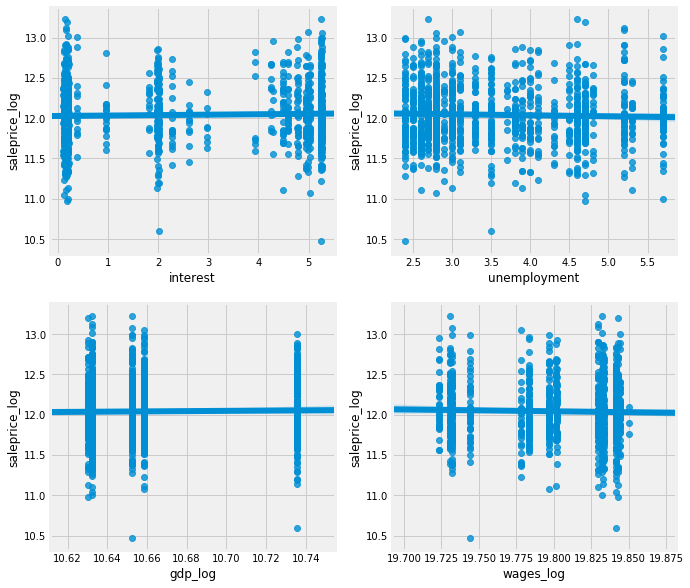

In [140]:
# Generate regression plots
plt.figure(figsize=(10, 10))

i = 1
for col in eco_features:
    plt.subplot(2, 2, i)
    sns.regplot(x=col, y="saleprice_log", data=df_train, fit_reg=True)
    i += 1

plt.tight_layout
plt.show()

It doesn't seem like any of the 4 additional features are correlated with saleprice_log. 

#### Feature engineering
Let's use Lasso regression to select features.

In [141]:
# Target vector
y = df_train["saleprice_log"]

# Feature vectors: old + new
X = df_train[features_final + eco_features]

# Lasso regularization
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(X, y))
coef = pd.Series(reg.coef_, index=X.columns)

Best alpha using built-in LassoCV: 0.129655
Best score using built-in LassoCV: 0.821196


Lasso picked 8 variables and eliminated the other 4 variables


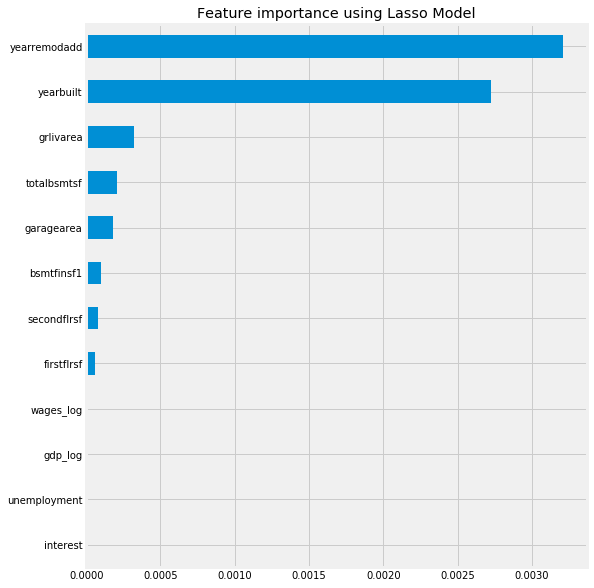

In [142]:
# Number of features picked and eliminated
print(
    "Lasso picked "
    + str(sum(coef != 0))
    + " variables and eliminated the other "
    + str(sum(coef == 0))
    + " variables"
)

# Plot feature importance
imp_coef = coef.sort_values()
import matplotlib

matplotlib.rcParams["figure.figsize"] = (8.0, 10.0)
imp_coef.plot(kind="barh")
plt.title("Feature importance using Lasso Model")

plt.show()

Interesting enough, Lasso didn't keep any of the 4 economic features we added, so the best models should be the same as before. However, just for the sake of practice, let's build new regression models (linear regression, Lasso, Ridge, and ElasticNet) with these new features to see if they improve the model performance at all.

#### Regression models

##### Prepare test data

In [143]:
# Add date sold
df_test.loc[:, "datesold"] = pd.to_datetime(
    df_test["yrsold"].astype(str) + "-" + df_test["mosold"].astype(str)
)

df_test["datesold"] = df_test["datesold"].apply(
    lambda x: "{:%Y-%m}".format(dt.strptime(str(x.date()), "%Y-%m-%d"))
)

# Add interest rate
df_test = pd.merge(
    df_test, interest[["datesold", "FEDFUNDS"]], on="datesold", how="left"
)

# Add unemployment rate
df_test = pd.merge(
    df_test, unemployment[["datesold", "AMES119URN"]], on="datesold", how="left"
)

# Add quarterly wages
df_test["quarter"] = (df_test["mosold"] - 1) // 3 + 1

df_test["yr_qr"] = df_test["yrsold"].astype(str) + "_" + df_test["quarter"].astype(str)

df_test = pd.merge(df_test, wages[["yr_qr", "ENUC111830010SA"]], on="yr_qr", how="left")

# Add per capita GDP
df_test = pd.merge(df_test, gdp[["yrsold", "PCRGMP11180"]], on="yrsold", how="left")

# Rename columns
df_test.rename(
    columns={
        "FEDFUNDS": "interest",
        "AMES119URN": "unemployment",
        "ENUC111830010SA": "wages",
        "PCRGMP11180": "gdp",
    },
    inplace=True,
)

# Log transformation
df_test["gdp_log"] = np.log(df_test["gdp"])
df_test["wages_log"] = np.log(df_test["wages"])

# Drop gdp old columns
df_test = df_test.drop(["gdp", "wages"], axis=1)

In [161]:
# Training data
y = df_train["saleprice_log"]
X = df_train[features_final + eco_features]

# Test data
test_y = df_test["saleprice_log"]
test_X = df_test[features_final + eco_features]

##### Hyperparameter tuning

In [165]:
# Use K-fold cross validation to select hyperparameters
lasso_cv = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0])

ridge_cv = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])


elastic_cv = ElasticNetCV(
    eps=None,
    n_alphas=None,
    alphas=[0.01, 0.1, 1.0, 10.0],
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    cv=5,
)


print("The best alpha for Lasso is {}.\n".format(lasso_cv.fit(X, y).alpha_))

print("The best alpha for Ridge is {}.\n".format(ridge_cv.fit(X, y).alpha_))

print(
    "The best alpha for ElasticNet is {} and the best l1_ratio is {}.".format(
        elastic_cv.fit(X, y).alpha_, elastic_cv.fit(X, y).l1_ratio_
    )
)

The best alpha for Lasso is 0.01.

The best alpha for Ridge is 1.0.

The best alpha for ElasticNet is 0.1 and the best l1_ratio is 0.5.


##### Train models

In [166]:
# Create model objects
lrm = LinearRegression()
lasso = Lasso(alpha=0.01)
ridge = Ridge(alpha=1.0)
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)

In [168]:
# Train on training data
lrm.fit(X, y)
lasso.fit(X, y)
ridge.fit(X, y)
elastic.fit(X, y)

# Display results
print("\nLinear regression coefficients: \n", lrm.coef_)
print("\nLinear regression intercept: \n", lrm.intercept_)
print("\nLasso coefficients: \n", lasso.coef_)
print("\nLasso intercept: \n", lasso.intercept_)
print("\nRidge coefficients: \n", ridge.coef_)
print("\nRidge intercept: \n", ridge.intercept_)
print("\nElasticNet coefficients: \n", elastic.coef_)
print("\nElasticNet intercept: \n", elastic.intercept_)


Linear regression coefficients: 
 [ 3.55362346e-03  2.76865219e-03  2.62821319e-04  1.99325172e-04
  1.68577591e-04  1.33150255e-04  1.19767568e-04  1.01241751e-04
  3.80589443e-03  6.50616110e-03  3.45743199e-01 -2.46450369e-02]

Linear regression intercept: 
 -4.628848352522288

Lasso coefficients: 
 [ 0.00350746  0.0027675   0.00026664  0.00019965  0.00017223  0.00012966
  0.00011425  0.00010183  0.00036387 -0.          0.         -0.        ]

Lasso intercept: 
 -1.3044325923378715

Ridge coefficients: 
 [ 3.54723898e-03  2.76850233e-03  2.62300957e-04  1.99025794e-04
  1.69897172e-04  1.33639465e-04  1.19718242e-04  1.01562845e-04
  2.57626211e-03 -1.93132645e-04  1.68642986e-01  3.64474654e-02]

Ridge intercept: 
 -3.9098709871882367

ElasticNet coefficients: 
 [ 3.40613992e-03  2.75469647e-03  2.85399462e-04  2.01484853e-04
  1.75157527e-04  1.11276643e-04  9.48709713e-05  1.01480998e-04
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00]

ElasticNet intercept: 
 

In [170]:
# Cross validation
scores_lrm = cross_val_score(lrm, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_lrm = np.sqrt(-scores_lrm)

scores_lasso = cross_val_score(lasso, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_lasso = np.sqrt(-scores_lasso)

scores_ridge = cross_val_score(ridge, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_ridge = np.sqrt(-scores)

scores_elastic = cross_val_score(elastic, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_elastic = np.sqrt(-scores)

print(
    "For Linear regression: \nRMSE of each fold is {} and the mean is {}.".format(
        rmse_lrm, rmse_lrm.mean()
    )
)

print(
    "\nFor Lasso regression: \nRMSE of each fold is {} and the mean is {}.".format(
        rmse_lasso, rmse_lasso.mean()
    )
)

print(
    "\nFor Ridge regression: \nRMSE of each fold is {} and the mean is {}.".format(
        rmse_ridge, rmse_ridge.mean()
    )
)

print(
    "\nFor ElasticNet regression: \nRMSE of each fold is {} and the mean is {}.".format(
        rmse_elastic, rmse_elastic.mean()
    )
)

print(
    "\nFor linear regression: \nRMSE of each fold is {} and the mean is {}.".format(
        rmse_scores, rmse_scores.mean()
    )
)

For Linear regression: 
RMSE of each fold is [0.16851753 0.15837087 0.15288349 0.16272581 0.16055899 0.16800734
 0.16268359 0.15642109 0.15556112 0.15882007] and the mean is 0.16045499064296354.

For Lasso regression: 
RMSE of each fold is [0.1692948  0.15844075 0.15268691 0.16357989 0.15854473 0.1663671
 0.16089035 0.15575399 0.15591693 0.16030468] and the mean is 0.160178013906409.

For Ridge regression: 
RMSE of each fold is [0.1691827  0.15861262 0.1527591  0.1634695  0.15848977 0.1664101
 0.16080265 0.15535779 0.15598346 0.16037259] and the mean is 0.16014402692195556.

For ElasticNet regression: 
RMSE of each fold is [0.1691827  0.15861262 0.1527591  0.1634695  0.15848977 0.1664101
 0.16080265 0.15535779 0.15598346 0.16037259] and the mean is 0.16014402692195556.

For linear regression: 
RMSE of each fold is [0.1691827  0.15861262 0.1527591  0.1634695  0.15848977 0.1664101
 0.16080265 0.15535779 0.15598346 0.16037259] and the mean is 0.16014402692195556.


In [171]:
# Predict test data
predict_lrm = lrm.predict(test_X)
predict_lasso = lasso.predict(test_X)
predict_ridge = ridge.predict(test_X)
predict_elastic = elastic.predict(test_X)

# Evaluation predictions
rmse_test_lrm = np.sqrt(metrics.mean_squared_error(test_y, predict_lrm))
rmse_test_lasso = np.sqrt(metrics.mean_squared_error(test_y, predict_lasso))
rmse_test_ridge = np.sqrt(metrics.mean_squared_error(test_y, predict_ridge))
rmse_test_elastic = np.sqrt(metrics.mean_squared_error(test_y, predict_elastic))

print("Linear regression: RMSE = {}.\n".format(rmse_test_lrm))
print("Lasso regression: RMSE = {}.\n".format(rmse_test_lasso))
print("Ridge regression: RMSE = {}.\n".format(rmse_test_ridge))
print("Elastic regression: RMSE = {}.\n".format(rmse_test_elastic))

Linear regression: RMSE = 0.15961615124900952.

Lasso regression: RMSE = 0.15997803233017466.

Ridge regression: RMSE = 0.1593320522325819.

Elastic regression: RMSE = 0.16012644429603584.



Additional features slightly improved model accuracy, but not by much. Ridge regression turns out to be the best model, followed by linear regression. However, differences between models are negligible.